## Validation for TCN customer risk models
--- 

In [1]:
import os
import datetime
import time
import torch
import feather
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdsutils.analysis_utils import *
from rdsutils.lightgbm_models import train_validate_lgb
from sklearn.metrics import average_precision_score, roc_auc_score

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

### Finished Objects
---

* Objects saved after both **TCN** and **LGBM** Validation:
    * model, separate df splits, feature importances, and other validation results:
        * `four_fold_lgbm_validation_object.pth`
    * DataFrames
        * `df.feather`: **account** level data for customer risk model
        * `transactions_df_w_valid_tcn_pred.feather`: **transactions_df** with tcn_preds
        * `4fold_modeling_dfs.pth`: 4-fold cross validation **transactions** DFs used for TCN and LGBM
        * `modeling_df_acct_with_preds.feather`: **account** level dataframe with all predictions. Features are the same as `df.feather`'s
        * `modeling_df_trans_with_preds.feather`: **transaction** level dataframe with all predictions. Features are the same as `transactions_df_w_valid_pred.feather` and `4fold_modeling_dfs.pth`'s
        
        

In [2]:
# tcn_valid_df = feather.read_dataframe("data/four_fold_tcn_pred_df.feather")
# lgbm_valid_object = torch.load("data/four_fold_lgbm_validation_object.pth")

## Validation: k fold cross validation vs. LGBM
---


### Train LGBM

In [5]:
modeling_dfs = torch.load("data/4fold_modeling_dfs.pth")

In [6]:
# process all folds of dataframes by onehot encode the categorical features
modeling_dfs_ = {}
for k, (train_df, test_df) in modeling_dfs.items():
    modeling_df_tmp = pd.concat([train_df, test_df], axis=0)
    t_code = pd.get_dummies(modeling_df_tmp.transaction_code, dtype=float)
    t_type = pd.get_dummies(modeling_df_tmp.transaction_type, dtype=float)
    modeling_df_tmp = pd.concat([modeling_df_tmp, t_code, t_type], axis=1, sort=False)
    modeling_df_tmp.drop(['transaction_code', 'transaction_type'], axis=1, inplace=True)
    train_df_ = modeling_df_tmp[modeling_df_tmp.borrower_id.isin(train_df.borrower_id.unique())]
    test_df_ = modeling_df_tmp[modeling_df_tmp.borrower_id.isin(test_df.borrower_id.unique())]
    modeling_dfs_[k] = (train_df_, test_df_)

In [5]:
modeling_dfs = modefeather.read_dataframeeatures_num = ['hr_of_transaction', 'has_transaction_comment', 'card_present_ind', 'days_since_first_transaction',
                'transaction_as_pct_of_balance', 'nr_past_transactions', 'international_transaction_flag']
features_cat = ['transaction_code', 'transaction_type']
target_col = ['target']
meta_cols = ['borrower_id', 'index']

# use a train fold for calculating pos_weight
# by construction, each fold has same pos_weight
df_train_tmp = modeling_dfs[0][0]  
pos_weight = 1/df_train_tmp.target.value_counts(normalize=True).loc[True]

seed = 12345
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 4,
    "num_leaves" : 10,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.4,
    "lambda_l1": 20,
    "min_data_in_leaf": 30,
    "scale_pos_weight": pos_weight, #df_train_basic['target'].count() / df_train_basic['target'].sum(),
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : seed,
    "verbosity" : 1,
    "seed": seed
}

# basic features


# features basic contains all the basic numerical variables and one hot encoded categorical variables. 
# just to make sure we won't include unnecessary features
features_basic = list(set(df_train_tmp.columns) - set(target_col) - set(meta_cols) - set(features_cat))

print('-' * 80)
print('current features: ',features_basic)
print('pos weight: ', pos_weight)
print('-' * 80)

%time modeling_dfs, feature_importance_df_basic, models_basic = lightgbm_models.train_lgb_baseline(modeling_dfs, features_basic, params, seed=12345, early_stopping_rounds=1000, verbose_eval=500)

--------------------------------------------------------------------------------
current features:  ['DWBILLPAY', 'DWSLROTP', 'ATM', 'DWACHRET', 'days_since_first_transaction', 'POSDD', 'DDWRTOFF', 'POS', 'ACHINDD', 'DWCKCB', 'DDCC', 'ACHDWIN', 'DDRAFNEW', 'DDATMREFUND', 'ACHDD', 'DWTRF', 'ACHDDIN', 'DDACHRET', 'DWATM', 'DDCHGOFF', 'DW', 'DDPROMO', 'hr_of_transaction', 'international_transaction_flag', 'DDCRDBILLREF', 'nr_past_transactions', 'DDFRDWO', 'BILLPAY', 'DD', 'TREASURYCHECK', 'DDMKT', 'INTEREST PAID', 'DIPD', 'ACH', 'P2P', 'DDPAYOUTADJ', 'ONUSCHECK', 'card_present_ind', 'DPNC', 'DCWIZERO', 'has_transaction_comment', 'DWCK', 'DDTRF', 'DWCARDREF', 'CHECK', 'DDBILLPAY', 'DDRAFCUS', 'DPND', 'ACHDW', 'transaction_as_pct_of_balance', 'DDA2ATXFR', 'ACHDWP2P', 'DWCRDBILLPAY', 'DWATMI', 'DDPC', 'DDMBR', 'DDCK', 'DWMBR', 'POSDW', 'DCWI', 'OTHER']
pos weight:  20.34183013043911
--------------------------------------------------------------------------------
Training until validation sco

In [6]:
lgbm_basic_pred = pd.concat(list(map(lambda x: x[1], modeling_dfs.values())), axis=0)
four_fold_lgbm_validation_object = {"lgbm_basic_pred": lgbm_basic_pred, 
                                    "modeling_dfs": modeling_dfs, 
                                    "feature_importance_df_basic":feature_importance_df_basic,
                                    "models_basic": models_basic}
# torch.save(four_fold_lgbm_validation_object, "four_fold_lgbm_validation_object.pth")

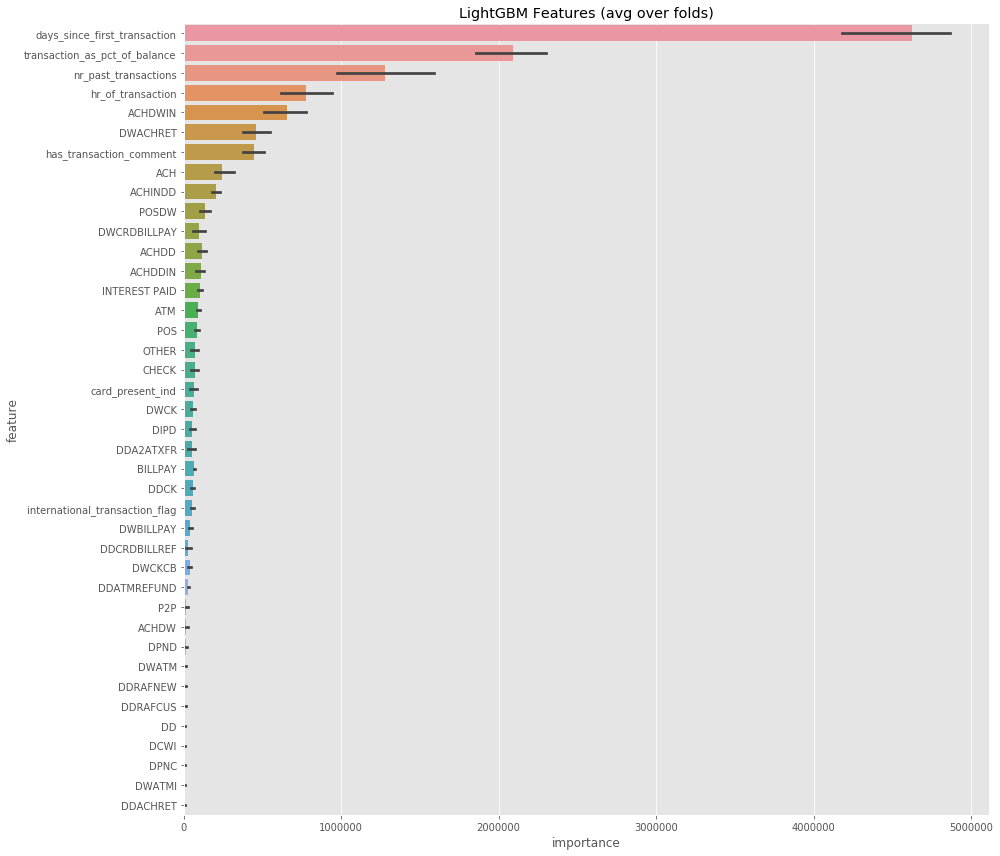

In [7]:
display_importances(feature_importance_df_basic)

### Analysis!
---

In [2]:
# load lgbm_validation_object
%time lgbm_valid_object = torch.load("data/four_fold_lgbm_validation_object.pth")

# load the tcn_object containing 4-fold cross validation conducted
%time tcn_valid_df = feather.read_dataframe("data/four_fold_tcn_pred_df.feather")
%time modeling_dfs = torch.load("data/4fold_modeling_dfs.pth")
lgbm_valid_df = lgbm_valid_object['lgbm_basic_pred']

CPU times: user 6.88 s, sys: 2.83 s, total: 9.71 s
Wall time: 11.4 s
CPU times: user 436 ms, sys: 87.6 ms, total: 523 ms
Wall time: 51.4 ms
CPU times: user 1.07 s, sys: 232 ms, total: 1.3 s
Wall time: 847 ms


In [3]:
tcn_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817174 entries, 0 to 817173
Data columns (total 24 columns):
index                             817174 non-null float64
borrower_id                       817174 non-null float64
tcn_pred                          817174 non-null float64
nr_past_returns                   817174 non-null float64
nr_past_transactions              817174 non-null float64
nr_pos_transactions               817174 non-null float64
nr_atm_transactions               817174 non-null float64
nr_direct_deposits                817174 non-null float64
rolling_trns_as_pct_of_bal        817174 non-null float64
rolling_mean_acc_bal              817174 non-null float64
nr_transactions_per_day           817174 non-null float64
transaction_as_pct_of_bal_min     817174 non-null float64
transaction_as_pct_of_balance     817174 non-null float64
card_present_ind                  817174 non-null float64
has_transaction_comment           817174 non-null float64
hr_of_transaction  

In [4]:
def no_bid_overlaps(df1, df2):
    return (len(set(df1.borrower_id.unique()).intersection(set(df2.borrower_id.unique()))) == 0)

bid_folds = {}
for k, (df_train_, df_test_) in modeling_dfs.items():
    assert(no_bid_overlaps(df_train_, df_test_))
    bid_folds[k] = (df_train_.borrower_id.unique(), df_test_.borrower_id.unique())

In [5]:
tcn_valid_df[['index', 'borrower_id']] = tcn_valid_df[['index', 'borrower_id']].astype(int)
lgbm_valid_df[['index', 'borrower_id']] = lgbm_valid_df[['index', 'borrower_id']].astype(int)

In [6]:
inference_pred = pd.merge(tcn_valid_df, lgbm_valid_df[['index', 'borrower_id', 'lgbm_basic_pred']], on=['index', 'borrower_id'])

In [7]:
inference_pred[['transaction_datetime', 'borrower_id', 'transaction_type', 'days_since_first_transaction', 'nr_past_transactions',
                'has_transaction_comment', 'hr_of_transaction', 'international_transaction_flag',
                'days_since_first_transaction', 'transaction_as_pct_of_balance', 'target']].head(10)

,transaction_datetime,borrower_id,transaction_type,days_since_first_transaction,nr_past_transactions,has_transaction_comment,hr_of_transaction,international_transaction_flag,days_since_first_transaction,transaction_as_pct_of_balance,target
0,2019-05-28 18:01:15,550,ACH,0.0,0.0,0.0,18.0,0.0,0.0,100.000000,False
1,2019-06-12 10:38:04,550,POS,14.0,1.0,0.0,10.0,0.0,14.0,-0.424898,False
2,2019-06-13 18:01:13,550,ACH,15.0,2.0,0.0,18.0,0.0,15.0,0.738822,False
3,2019-06-14 05:50:32,550,ACH,16.0,4.0,0.0,5.0,0.0,16.0,0.000210,False
4,2019-06-14 05:50:32,550,ACH,16.0,3.0,0.0,5.0,0.0,16.0,0.000520,False
5,2019-06-14 05:50:54,550,ACH,16.0,5.0,0.0,5.0,0.0,16.0,-0.000729,False
6,2018-12-12 14:48:08,1256,ACH,0.0,0.0,0.0,14.0,0.0,0.0,100.000000,False
7,2018-12-20 21:27:38,1256,POS,8.0,1.0,0.0,21.0,0.0,8.0,-0.005565,False
8,2018-12-21 05:55:44,1256,ACH,8.0,2.0,0.0,5.0,0.0,8.0,13.051200,False
9,2019-01-04 05:57:27,1256,ACH,22.0,3.0,0.0,5.0,0.0,22.0,0.831402,False


In [8]:
inference_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817174 entries, 0 to 817173
Data columns (total 25 columns):
index                             817174 non-null int64
borrower_id                       817174 non-null int64
tcn_pred                          817174 non-null float64
nr_past_returns                   817174 non-null float64
nr_past_transactions              817174 non-null float64
nr_pos_transactions               817174 non-null float64
nr_atm_transactions               817174 non-null float64
nr_direct_deposits                817174 non-null float64
rolling_trns_as_pct_of_bal        817174 non-null float64
rolling_mean_acc_bal              817174 non-null float64
nr_transactions_per_day           817174 non-null float64
transaction_as_pct_of_bal_min     817174 non-null float64
transaction_as_pct_of_balance     817174 non-null float64
card_present_ind                  817174 non-null float64
has_transaction_comment           817174 non-null float64
hr_of_transaction      

#### Performance over the folds
---

--------- auc ----------
tcn:  0.8556621351148973
lgbm:  0.837762929600945
--------- ap ----------
tcn:  0.529018532398513
lgbm:  0.38204361566258366


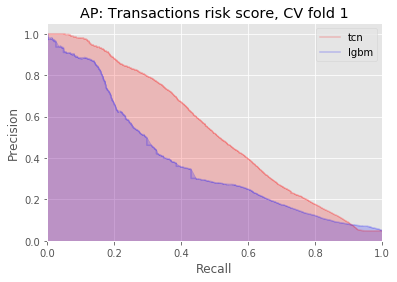

--------- auc ----------
tcn:  0.8836506335498668
lgbm:  0.8938709664273738
--------- ap ----------
tcn:  0.5221710612058347
lgbm:  0.4818883979571415


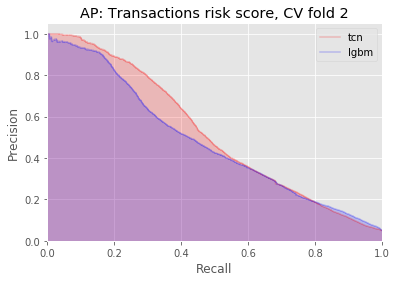

--------- auc ----------
tcn:  0.9067965549937071
lgbm:  0.8858215898150181
--------- ap ----------
tcn:  0.5387131376808851
lgbm:  0.46507823323592756


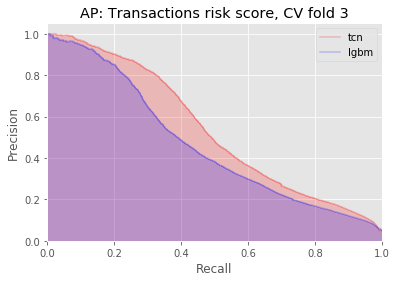

--------- auc ----------
tcn:  0.9261067125645437
lgbm:  0.9177221074219979
--------- ap ----------
tcn:  0.5664699377324476
lgbm:  0.522265920585771


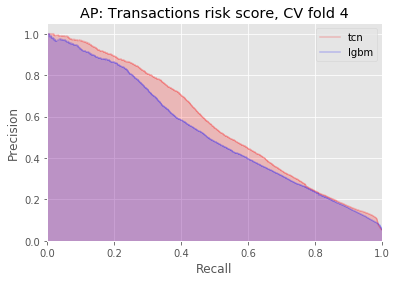

In [9]:
tcn_aucs = []
tcn_aps = []
lgbm_aucs = []
lgbm_aps = []

for k, (df_train_, df_test_) in lgbm_valid_object['modeling_dfs'].items():
    df_tmp = inference_pred[inference_pred.borrower_id.isin(df_test_.borrower_id.unique())]
    y_scores = [(df_tmp.tcn_pred, 'tcn'),
                (df_tmp.lgbm_basic_pred, 'lgbm')]
    colors = ['r', 'b']
    
    tcn_auc = roc_auc_score(df_tmp.target, df_tmp.tcn_pred)
    lgbm_auc = roc_auc_score(df_tmp.target, df_tmp.lgbm_basic_pred)
    tcn_ap = average_precision_score(df_tmp.target, df_tmp.tcn_pred)
    lgbm_ap = average_precision_score(df_tmp.target, df_tmp.lgbm_basic_pred)
    tcn_aucs.append(tcn_auc)
    lgbm_aucs.append(lgbm_auc)
    tcn_aps.append(tcn_ap)
    lgbm_aps.append(lgbm_ap)
    
    print("--------- auc ----------")
    print("tcn: ", tcn_auc)
    print("lgbm: ", lgbm_auc)
    
    print("--------- ap ----------")
    print("tcn: ", tcn_ap)
    print("lgbm: ", lgbm_ap)
    
    plot_pr_curve_mult(df_tmp.target, y_scores, 'AP: Transactions risk score, CV fold {}'.format(k+1), colors)
    plt.show()
    

In [10]:
np.array(tcn_aucs).round(2), np.array(lgbm_aucs).round(2)

(array([0.86, 0.88, 0.91, 0.93]), array([0.84, 0.89, 0.89, 0.92]))

In [11]:
np.array(tcn_aps).round(2), np.array(lgbm_aps).round(2)

(array([0.53, 0.52, 0.54, 0.57]), array([0.38, 0.48, 0.47, 0.52]))

#### TCN and LGBM Individual Performances: includes all returns
---

In [12]:
# tcn
print("validation auc: ", roc_auc_score(inference_pred.target.astype(int), inference_pred.tcn_pred))
build_summary(inference_pred.target, inference_pred.tcn_pred, np.linspace(90, 100, 10, endpoint=False))

validation auc:  0.8920631055001426


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.114694,67.625248,65.855176,81718,26456,55262,13717
1,91.0,0.128531,65.231284,63.652204,73546,25571,47975,14602
2,92.0,0.145253,62.414721,61.162970,65374,24571,40803,15602
3,93.0,0.164552,59.256096,58.188335,57373,23376,33997,16797
4,94.0,0.188910,55.322143,54.529161,49031,21906,27125,18267
5,95.0,0.221702,50.424631,50.421925,40859,20256,20603,19917
6,96.0,0.268116,43.537186,45.941304,32687,18456,14231,21717
7,97.0,0.348652,33.720835,40.447564,24516,16249,8267,23924
8,98.0,0.522604,21.867352,31.787519,16344,12770,3574,27403
9,99.0,0.783197,9.214391,18.467628,8172,7419,753,32754


In [13]:
# lgbm
print("validation auc: ", roc_auc_score(inference_pred.target.astype(int), inference_pred.lgbm_basic_pred))
build_summary(inference_pred.target, inference_pred.lgbm_basic_pred, np.linspace(90, 100, 10, endpoint=False))

validation auc:  0.8836510022270888


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.688156,70.000489,61.023573,81718,24515,57203,15658
1,91.0,0.703625,68.221763,58.599059,74079,23541,50538,16632
2,92.0,0.727463,66.076728,55.203744,65374,22177,43197,17996
3,93.0,0.749116,63.827298,51.574441,57278,20719,36559,19454
4,94.0,0.774067,61.188377,47.444801,49109,19060,30049,21113
5,95.0,0.806521,57.429208,43.297737,40859,17394,23465,22779
6,96.0,0.839178,52.712087,38.476091,32687,15457,17230,24716
7,97.0,0.872310,46.341165,32.745874,24516,13155,11361,27018
8,98.0,0.904338,36.869799,25.683917,16344,10318,6026,29855
9,99.0,0.957687,18.220754,16.635551,8172,6683,1489,33490


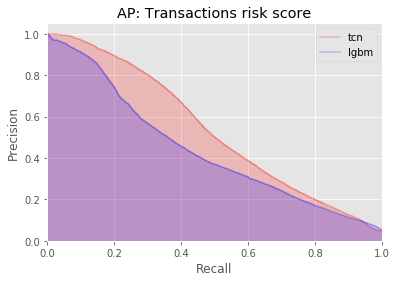

In [14]:
# average precision
y_scores = [(inference_pred.tcn_pred, 'tcn'),
            (inference_pred.lgbm_basic_pred, 'lgbm')]
colors = ['r', 'b']
plot_pr_curve_mult(inference_pred.target, y_scores, 'AP: Transactions risk score', colors)
plt.show()

#### Individual Performances: catching first return
---

In [15]:
inference_pred['is_return'] = inference_pred['transaction_code'].isin(['DWACHRET', 'DWCKCB'])
inference_pred['nr_past_returns'] = inference_pred.groupby('borrower_id')['is_return'].cumsum()
inference_pred_1st_return = inference_pred[inference_pred.nr_past_returns == 0]

In [16]:
# tcn
print('auc for tcn first returns: ', roc_auc_score(inference_pred_1st_return.target.astype(int), inference_pred_1st_return.tcn_pred))
build_summary(inference_pred_1st_return.target, inference_pred_1st_return.tcn_pred, np.linspace(90, 100, 10, endpoint=False))

auc for tcn first returns:  0.8765237942656713


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.096946,78.850280,62.342370,76436,16166,60270,9765
1,91.0,0.108558,77.472999,59.762446,68793,15497,53296,10434
2,92.0,0.122193,75.803366,57.059118,61149,14796,46353,11135
3,93.0,0.136998,73.859006,53.939300,53506,13987,39519,11944
4,94.0,0.154808,71.627927,50.179322,45862,13012,32850,12919
5,95.0,0.176787,69.090719,45.698199,38338,11850,26488,14081
6,96.0,0.205771,65.795585,40.330107,30575,10458,20117,15473
7,97.0,0.245774,61.253325,34.264008,22931,8885,14046,17046
8,98.0,0.313347,53.286677,27.542324,15289,7142,8147,18789
9,99.0,0.467315,40.777080,17.457869,7644,4527,3117,21404


In [17]:
# lgbm
print('auc for lgbm first returns: ', roc_auc_score(inference_pred_1st_return.target.astype(int), inference_pred_1st_return.lgbm_basic_pred))
build_summary(inference_pred_1st_return.target, inference_pred_1st_return.lgbm_basic_pred, np.linspace(90, 100, 10, endpoint=False))

auc for lgbm first returns:  0.8833039813094332


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.667583,79.123984,61.536385,76437,15957,60480,9974
1,91.0,0.691469,78.079147,58.189040,68834,15089,53745,10842
2,92.0,0.706063,76.782940,54.749142,61149,14197,46952,11734
3,93.0,0.730505,75.406496,50.746211,53506,13159,40347,12772
4,94.0,0.749926,74.037329,45.918013,45862,11907,33955,14024
5,95.0,0.777044,72.418034,40.650187,38217,10541,27676,15390
6,96.0,0.810167,69.939493,35.444063,30575,9191,21384,16740
7,97.0,0.843009,66.669574,29.474374,22931,7643,15288,18288
8,98.0,0.877212,62.002878,22.401759,15288,5809,9479,20122
9,99.0,0.912529,53.113553,13.821295,7644,3584,4060,22347


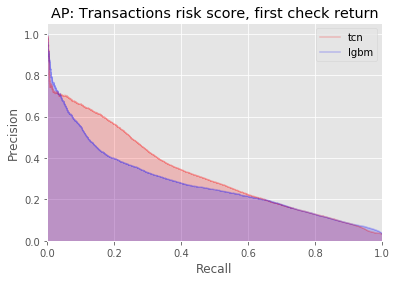

In [18]:
# average precision of 1st return
y_scores = [(inference_pred_1st_return.tcn_pred, 'tcn'),
            (inference_pred_1st_return.lgbm_basic_pred, 'lgbm')]
colors = ['r', 'b']
plot_pr_curve_mult(inference_pred_1st_return.target, y_scores, 'AP: Transactions risk score, first check return', colors)
plt.show()

#### Segment on users based on how many transactions they have
---

In [19]:
bins = [0, 4, 16, 32, 64, np.inf]
print("bins: ", bins)
trans_count = inference_pred.groupby("borrower_id")['borrower_id'].count().rename('counts')
trans_count_bins = pd.cut(trans_count, bins, labels=False, right=False)
print(trans_count_bins.value_counts())

bids = {}
def fn(x):
    bids[x.bin.unique().item()] = x.borrower_id.values
    
trans_count_bins.rename('bin').to_frame().reset_index().groupby('bin').apply(fn)

bins:  [0, 4, 16, 32, 64, inf]
1    8802
0    4631
4    3595
2    3511
3    2769
Name: counts, dtype: int64


""


False    0.80731
True     0.19269
Name: target, dtype: float64
false vs true ratio:  5.189690721649485
tcn ap:  0.7809675218942004
lgbm ap:  0.7809291118897641


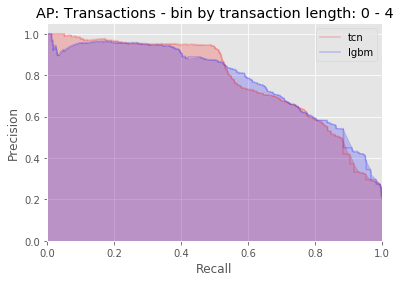

False    0.867389
True     0.132611
Name: target, dtype: float64
false vs true ratio:  7.540843854537607
tcn ap:  0.7437689422932813
lgbm ap:  0.6783861087271441


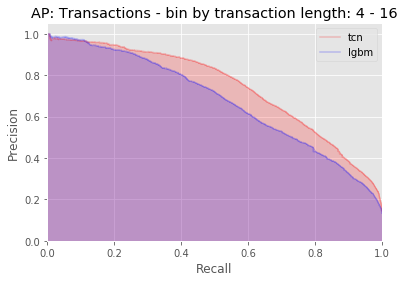

False    0.896716
True     0.103284
Name: target, dtype: float64
false vs true ratio:  9.682058209505096
tcn ap:  0.7333777076300843
lgbm ap:  0.5973250733107228


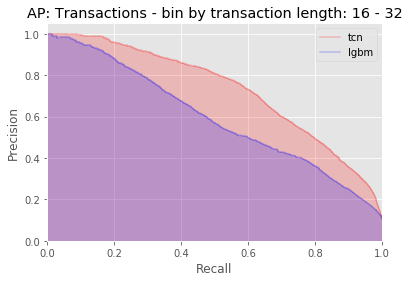

False    0.945647
True     0.054353
Name: target, dtype: float64
false vs true ratio:  18.398153575615474
tcn ap:  0.6401937320924235
lgbm ap:  0.4345143401982058


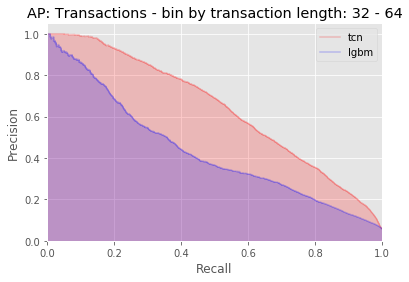

False    0.973727
True     0.026273
Name: target, dtype: float64
false vs true ratio:  38.062361597256945
tcn ap:  0.2079310795243887
lgbm ap:  0.17407410207274537


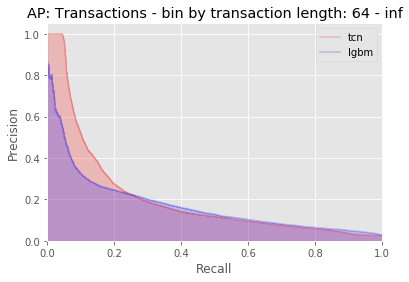

In [20]:
# on test data
for b, bin_ in bids.items():
    df_tmp = inference_pred[inference_pred.borrower_id.isin(bin_)].copy()
    print(df_tmp.target.value_counts(normalize=True))
    print("false vs true ratio: ", 1/df_tmp.target.value_counts(normalize=True).loc[True])
    print("tcn ap: ", average_precision_score(df_tmp.target, df_tmp.tcn_pred))
    print("lgbm ap: ", average_precision_score(df_tmp.target, df_tmp.lgbm_basic_pred))
    
    y_scores = [(df_tmp.tcn_pred, 'tcn'),
                (df_tmp.lgbm_basic_pred, 'lgbm')]
    colors = ['r', 'b']
    plot_pr_curve_mult(df_tmp.target, y_scores, 'AP: Transactions - bin by transaction length: {} - {}'.format(bins[b], bins[b+1]), colors)
    plt.show()

False    0.886494
True     0.113506
Name: target, dtype: float64
false vs true ratio:  8.810077519379846
tcn ap:  0.4243364017935798
lgbm ap:  0.46136317585172465


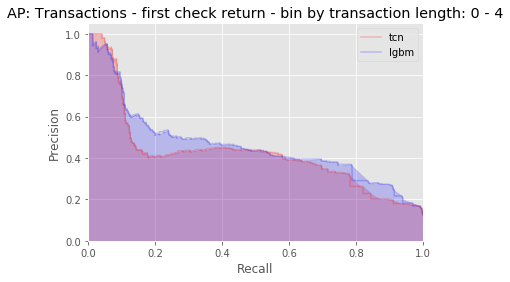

False    0.916851
True     0.083149
Name: target, dtype: float64
false vs true ratio:  12.026550315633123
tcn ap:  0.5035204658501488
lgbm ap:  0.46504057397299486


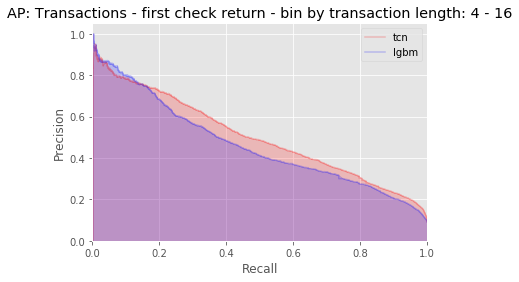

False    0.929613
True     0.070387
Name: target, dtype: float64
false vs true ratio:  14.207167497125335
tcn ap:  0.5455344450856865
lgbm ap:  0.42915338676796244


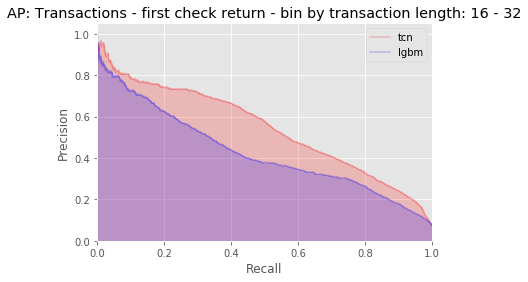

False    0.962378
True     0.037622
Name: target, dtype: float64
false vs true ratio:  26.58045849098598
tcn ap:  0.4570907489609449
lgbm ap:  0.2998316237291741


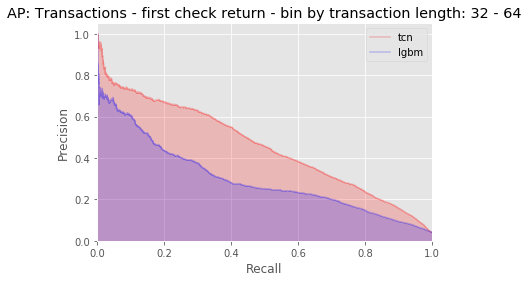

False    0.980275
True     0.019725
Name: target, dtype: float64
false vs true ratio:  50.69710263211589
tcn ap:  0.1211775098685825
lgbm ap:  0.13162307064792095


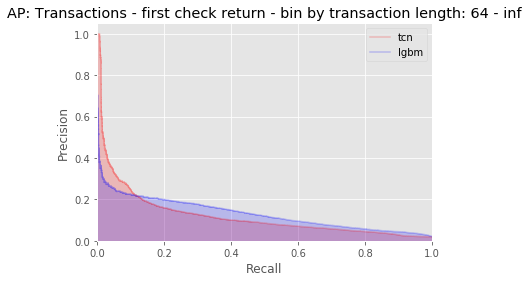

In [21]:
# on test data
for b, bin_ in bids.items():
    df_tmp = inference_pred_1st_return[inference_pred_1st_return.borrower_id.isin(bin_)].copy()
    print(df_tmp.target.value_counts(normalize=True))
    print("false vs true ratio: ", 1/df_tmp.target.value_counts(normalize=True).loc[True])

    print("tcn ap: ", average_precision_score(df_tmp.target, df_tmp.tcn_pred))
    print("lgbm ap: ", average_precision_score(df_tmp.target, df_tmp.lgbm_basic_pred))
    
    y_scores = [(df_tmp.tcn_pred, 'tcn'),
                (df_tmp.lgbm_basic_pred, 'lgbm')]
    colors = ['r', 'b']
    plot_pr_curve_mult(df_tmp.target, y_scores, 'AP: Transactions - first check return - bin by transaction length: {} - {}'.format(bins[b], bins[b+1]), colors)
    plt.show()

#### Segment on nr_past_transactions
---

In [22]:
inference_pred_tmp = inference_pred.copy()
bins = [0, 4, 16, 32, 64, np.inf]
print("bins: ", bins)
inference_pred_tmp['bin'] = pd.cut(inference_pred_tmp.nr_past_transactions, bins, labels=False, right=False)

bins:  [0, 4, 16, 32, 64, inf]


In [23]:
inference_pred_tmp.bin.value_counts()

4    302755
1    153173
3    151981
2    124489
0     84776
Name: bin, dtype: int64

False    75376
True      9400
Name: target, dtype: int64
tcn ap:  0.5310632994764141
lgbm ap:  0.503849206834402
false vs true ratio:  9.01872340425532


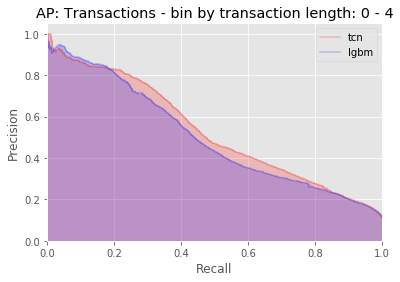

False    141366
True      11807
Name: target, dtype: int64
tcn ap:  0.6964061750460453
lgbm ap:  0.5328817720593332
false vs true ratio:  12.973066824764969


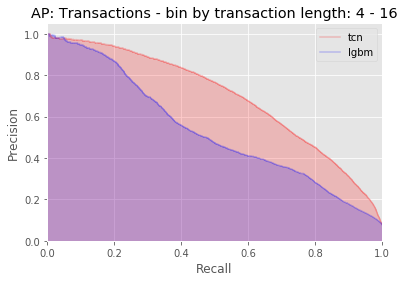

False    118250
True       6239
Name: target, dtype: int64
tcn ap:  0.6588009095007561
lgbm ap:  0.46680614762838823
false vs true ratio:  19.95335790992146


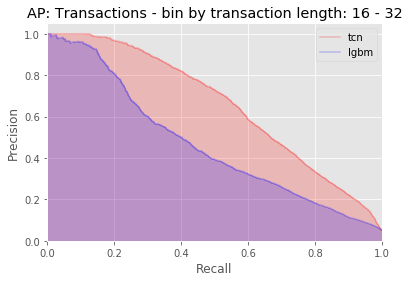

False    147237
True       4744
Name: target, dtype: int64
tcn ap:  0.47890553911256556
lgbm ap:  0.35161822450626545
false vs true ratio:  32.0364671163575


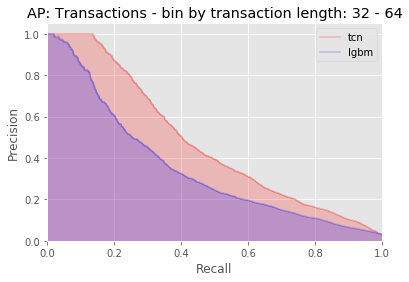

False    294772
True       7983
Name: target, dtype: int64
tcn ap:  0.16723545958376912
lgbm ap:  0.24765848284668399
false vs true ratio:  37.92496555179757


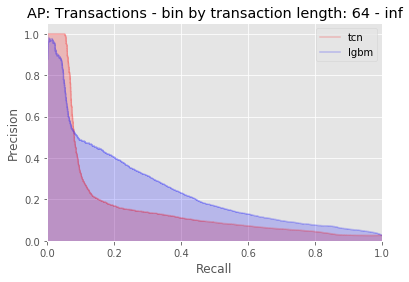

In [24]:
# on test data
for b, bin_ in bids.items():
    df_tmp = inference_pred_tmp[inference_pred_tmp.bin == b].copy()
    print(df_tmp.target.value_counts())
    print("tcn ap: ", average_precision_score(df_tmp.target, df_tmp.tcn_pred))
    print("lgbm ap: ", average_precision_score(df_tmp.target, df_tmp.lgbm_basic_pred))
    print("false vs true ratio: ", 1/df_tmp.target.value_counts(normalize=True).loc[True])

    y_scores = [(df_tmp.tcn_pred, 'tcn'),
                (df_tmp.lgbm_basic_pred, 'lgbm')]
    colors = ['r', 'b']
    plot_pr_curve_mult(df_tmp.target, y_scores, 'AP: Transactions - bin by transaction length: {} - {}'.format(bins[b], bins[b+1]), colors)
    plt.show()

### TCN + LGBM
---

In [25]:
modeling_df = inference_pred.copy()

In [26]:
# account level data
df = feather.read_dataframe("df.feather")
df['borrower_id'] = df['borrower_id'].astype(int)
inference_pred['borrower_id'] = inference_pred['borrower_id'].astype(int)
inference_pred.sort_values(['index', 'transaction_datetime'], inplace=True)
df_acct = pd.merge_asof(df[df.columns[~df.columns.isin(['transaction_datetime'])]], 
                        inference_pred[['lgbm_basic_pred',
                                        'tcn_pred',
                                        'transaction_type',
                                        'card_present_ind',
                                        'transaction_as_pct_of_balance',
                                        'hr_of_transaction',
                                        'randf',
                                        'transaction_code',
                                        'has_transaction_comment',
                                        'index',
                                        'international_transaction_flag',
                                        'borrower_id', 
                                        'transaction_datetime']], left_on='reporting_date', right_on='transaction_datetime', by='borrower_id')

df_acct['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df_acct['age'] = (pd.datetime.today() - df_acct['date_of_birth']).dt.days

modeling_df_acct = df_acct[~df_acct['latest_acc_bal'].isna() & ~df_acct['is_indeterminate']]
modeling_df_acct = modeling_df_acct.drop_duplicates(subset=['borrower_id', 'reporting_date_id'], keep='first')

modeling_df_acct.reset_index(drop=True).to_feather("modeling_df_acct_with_four_fold.feather")

In [27]:
features = ['fico_score', 'vantage_score', 'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'iln5520', 'bcx3423', 'days_since_first_transaction',
            'stu5031', 'fraud_score_1', 'fraud_score_2', 'phone_risk_score', 'email_risk_score', 'address_risk_score', 'age',
            'nr_past_transactions', 'nr_pos_transactions', 'nr_direct_deposits', 'rolling_trns_as_pct_of_bal', 'rolling_mean_acc_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_bal_min']

features_tcn = features + ['tcn_pred']
features_lgbm = features + ['lgbm_basic_pred']
features_tcn_lgbm = features + ['tcn_pred', 'lgbm_basic_pred']
target_col_name = 'target'

seed = 12345 
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 3,
    "num_leaves" : 9,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.5,
    "lambda_l1": 5,
    "min_data_in_leaf": 30,
    "scale_pos_weight": modeling_df_acct['target'].count() / modeling_df_acct['target'].sum(),
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : seed,
    "verbosity" : 1,
    "seed": seed
}

print("training on baseline, no transaction risk scores")
print("features: ", features)
print("\n")
%time pred_bl, feature_importance_df, models, auc = lightgbm_models.train_lgb_baseline_k_fold(modeling_df_acct, features, params, num_folds=4, verbose_eval=1000, early_stopping_rounds=1000)

training on baseline, no transaction risk scores
features:  ['fico_score', 'vantage_score', 'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'iln5520', 'bcx3423', 'days_since_first_transaction', 'stu5031', 'fraud_score_1', 'fraud_score_2', 'phone_risk_score', 'email_risk_score', 'address_risk_score', 'age', 'nr_past_transactions', 'nr_pos_transactions', 'nr_direct_deposits', 'rolling_trns_as_pct_of_bal', 'rolling_mean_acc_bal', 'nr_transactions_per_day', 'transaction_as_pct_of_bal_min']


Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.994735	test's auc: 0.983458
Early stopping, best iteration is:
[373]	train's auc: 0.989777	test's auc: 0.984008
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.994717	test's auc: 0.986319
Early stopping, best iteration is:
[783]	train's auc: 0.993491	test's auc: 0.986357
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.995237	test's auc: 0.981802
[

In [28]:
%time pred_bl_tcn, feature_importance_df_tcn, models_tcn, auc_tcn = lightgbm_models.train_lgb_baseline_k_fold(modeling_df_acct, features_tcn, params, num_folds=4, verbose_eval=1000, early_stopping_rounds=1000)

Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997358	test's auc: 0.991083
Early stopping, best iteration is:
[190]	train's auc: 0.99183	test's auc: 0.991985
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997701	test's auc: 0.990602
Early stopping, best iteration is:
[631]	train's auc: 0.996273	test's auc: 0.990885
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997717	test's auc: 0.987873
Early stopping, best iteration is:
[981]	train's auc: 0.997662	test's auc: 0.987917
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997955	test's auc: 0.9879
Early stopping, best iteration is:
[294]	train's auc: 0.993773	test's auc: 0.988652
AUC =  0.9893076159314357
CPU times: user 1h 34min 51s, sys: 52.5 s, total: 1h 35min 44s
Wall time: 12min 2s


In [29]:
%time pred_bl_lgbm, feature_importance_df_lgbm, models_lgbm, auc_lgbm = lightgbm_models.train_lgb_baseline_k_fold(modeling_df_acct, features_lgbm, params, num_folds=4, verbose_eval=1000, early_stopping_rounds=1000)

Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.996523	test's auc: 0.988266
Early stopping, best iteration is:
[264]	train's auc: 0.991292	test's auc: 0.989519
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.996905	test's auc: 0.98966
[2000]	train's auc: 0.998873	test's auc: 0.989202
Early stopping, best iteration is:
[1067]	train's auc: 0.997119	test's auc: 0.989666
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997022	test's auc: 0.985414
Early stopping, best iteration is:
[820]	train's auc: 0.996373	test's auc: 0.985467
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997093	test's auc: 0.985206
Early stopping, best iteration is:
[255]	train's auc: 0.991713	test's auc: 0.985933
AUC =  0.9873225748130952
CPU times: user 1h 32min 20s, sys: 49.1 s, total: 1h 33min 9s
Wall time: 11min 42s


In [30]:
%time pred_bl_tcn_lgbm, feature_importance_df_tcn_lgbm, models_tcn_lgbm, auc_tcn_lgbm = lightgbm_models.train_lgb_baseline_k_fold(modeling_df_acct, features_tcn_lgbm, params, num_folds=4, verbose_eval=1000, early_stopping_rounds=1000)

Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997455	test's auc: 0.990612
Early stopping, best iteration is:
[201]	train's auc: 0.991874	test's auc: 0.991741
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997841	test's auc: 0.990586
Early stopping, best iteration is:
[706]	train's auc: 0.996766	test's auc: 0.990773
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.99769	test's auc: 0.9861
Early stopping, best iteration is:
[224]	train's auc: 0.993086	test's auc: 0.987551
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.997959	test's auc: 0.987583
Early stopping, best iteration is:
[280]	train's auc: 0.993662	test's auc: 0.988557
AUC =  0.9894160143265769
CPU times: user 1h 20min 22s, sys: 45.1 s, total: 1h 21min 7s
Wall time: 10min 12s


In [31]:
modeling_df_acct['acct_level_pred'] = pred_bl
modeling_df_acct['acct_level_w_tcn_pred'] = pred_bl_tcn
modeling_df_acct['acct_level_w_lgbm_pred'] = pred_bl_lgbm
modeling_df_acct['acct_level_w_tcn_lgbm_pred'] = pred_bl_tcn_lgbm

#### Compare customer level models side by side
---
* Customer w/o pred(transaction risk score)
* Customer w tcn risk pred
* Customer w lgbm risk pred

In [2]:
modeling_df_acct =feather.read_dataframe("data/modeling_df_acct_oof_with_score.feather")

In [4]:
modeling_df_acct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096968 entries, 0 to 2096967
Data columns (total 66 columns):
user_id                               int64
borrower_id                           int64
reporting_date_id                     int64
account_closed_date                   object
account_closed_reason                 object
account_restricted_reason             object
date_of_birth                         datetime64[ns]
fico_score                            float64
vantage_score                         float64
iqt9415                               float64
all7120                               float64
mtf5820                               float64
bcc7120                               float64
bcc2800                               float64
iln5520                               float64
bcx3423                               float64
use0300                               float64
use8220                               float64
stu5031                               float64
reporting_date 

#### without transaction risk score, with TCN risk score, and with LGBM risk score

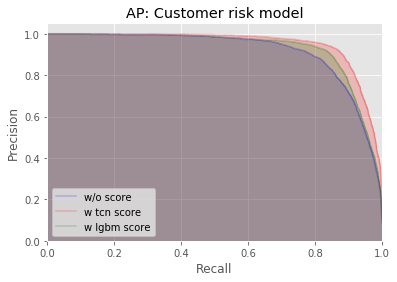

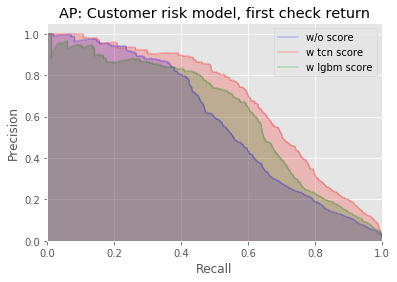

In [9]:
# average precision
y_scores = [(modeling_df_acct.acct_level_no_tcn_pred, 'w/o score'),
            (modeling_df_acct.acct_level_w_tcn_pred, 'w tcn score'),
            (modeling_df_acct.acct_level_w_lgbm_basic_pred, 'w lgbm score')]
colors = ['b', 'r', 'g']
plot_pr_curve_mult(modeling_df_acct.target, y_scores, 'AP: Customer risk model', colors)
plt.show()

# average precision of 1st return
modeling_df_acct_1st_return = modeling_df_acct[(modeling_df_acct['nr_past_returns'] == 0)]

y_scores = [(modeling_df_acct_1st_return.acct_level_no_tcn_pred, 'w/o score'),
            (modeling_df_acct_1st_return.acct_level_w_tcn_pred, 'w tcn score'),
            (modeling_df_acct_1st_return.acct_level_w_lgbm_basic_pred, 'w lgbm score')]
colors = ['b', 'r', 'g']
plot_pr_curve_mult(modeling_df_acct_1st_return.target, y_scores, 'AP: Customer risk model, first check return', colors)
plt.show()

#### Just with and without TCN risk score

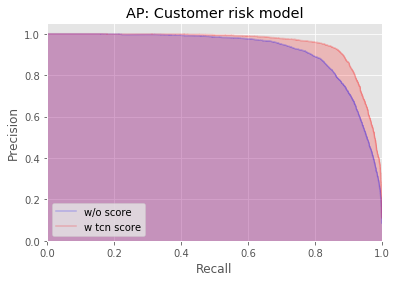

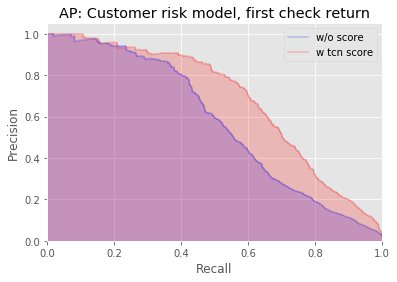

In [10]:
# average precision
y_scores = [(modeling_df_acct.acct_level_no_tcn_pred, 'w/o score'),
            (modeling_df_acct.acct_level_w_tcn_pred, 'w tcn score')]

colors = ['b', 'r']
plot_pr_curve_mult(modeling_df_acct.target, y_scores, 'AP: Customer risk model', colors)
plt.show()

# average precision of 1st return
modeling_df_acct_1st_return = modeling_df_acct[(modeling_df_acct['nr_past_returns'] == 0)]

y_scores = [(modeling_df_acct_1st_return.acct_level_no_tcn_pred, 'w/o score'),
            (modeling_df_acct_1st_return.acct_level_w_tcn_pred, 'w tcn score')]
colors = ['b', 'r']
plot_pr_curve_mult(modeling_df_acct_1st_return.target, y_scores, 'AP: Customer risk model, first check return', colors)
plt.show()

In [33]:
print("no trans score preds")
build_summary(modeling_df_acct.target, modeling_df_acct.acct_level_pred, np.linspace(90, 100, 10, endpoint=False))

no trans score preds


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.561901,39.736382,90.041825,209697,126371,83326,13976
1,91.0,0.626813,34.263993,88.409442,188755,124080,64675,16267
2,92.0,0.708199,27.759634,86.368073,167794,121215,46579,19132
3,93.0,0.802362,20.344973,83.346990,146852,116975,29877,23372
4,94.0,0.898991,12.447645,78.491881,125823,110161,15662,30186
5,95.0,0.952562,6.907697,69.568997,104883,97638,7245,42709
6,96.0,0.976648,3.148583,57.883674,83879,81238,2641,59109
7,97.0,0.988624,1.529169,44.139169,62910,61948,962,78399
8,98.0,0.994989,0.965596,29.596643,41943,41538,405,98809
9,99.0,0.998107,0.190703,14.916600,20975,20935,40,119412


In [34]:
print("with tcn preds")
build_summary(modeling_df_acct.target, modeling_df_acct.acct_level_w_tcn_pred, np.linspace(90, 100, 10, endpoint=False))

with tcn preds


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.492075,37.601991,93.231776,209699,130848,78851,9499
1,91.0,0.557692,31.613778,91.962065,188731,129066,59665,11281
2,92.0,0.646210,24.500110,90.261281,167787,126679,41108,13668
3,93.0,0.771770,16.125077,87.725423,146790,123120,23670,17227
4,94.0,0.910537,7.312790,83.111858,125848,116645,9203,23702
5,95.0,0.977301,3.498164,72.097729,104855,101187,3668,39160
6,96.0,0.989849,2.430883,58.312611,83879,81840,2039,58507
7,97.0,0.994462,1.955112,43.949639,62912,61682,1230,78665
8,98.0,0.996941,0.579178,29.721334,41956,41713,243,98634
9,99.0,0.998792,0.443026,14.890949,20992,20899,93,119448


In [35]:
print("with lgbm preds")
build_summary(modeling_df_acct.target, modeling_df_acct.acct_level_w_lgbm_pred, np.linspace(90, 100, 10, endpoint=False))

with lgbm preds


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.517495,38.349841,92.115257,209701,129281,80420,11066
1,91.0,0.585031,32.716762,90.479312,188732,126985,61747,13362
2,92.0,0.672464,25.714865,88.794203,167759,124620,43139,15727
3,93.0,0.786097,17.513351,86.283996,146808,121097,25711,19250
4,94.0,0.907522,8.832529,81.730283,125819,114706,11113,25641
5,95.0,0.971860,4.056039,71.681618,104856,100603,4253,39744
6,96.0,0.987109,2.792743,58.108118,83896,81553,2343,58794
7,97.0,0.992985,1.966921,43.964602,62941,61703,1238,78644
8,98.0,0.996509,1.120649,29.548191,41940,41470,470,98877
9,99.0,0.998400,0.742256,14.863873,21017,20861,156,119486


In [36]:
print("with tcn & lgbm preds")
build_summary(modeling_df_acct.target, modeling_df_acct.acct_level_w_tcn_lgbm_pred, np.linspace(90, 100, 10, endpoint=False))

with tcn & lgbm preds


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.505355,37.881606,92.817089,209706,130266,79440,10081
1,91.0,0.568413,31.844360,91.657820,188743,128639,60104,11708
2,92.0,0.652606,24.498239,90.248456,167759,126661,41098,13686
3,93.0,0.784442,15.904926,87.956280,146791,123444,23347,16903
4,94.0,0.920843,7.145185,83.242962,125819,116829,8990,23518
5,95.0,0.978655,3.344683,72.211020,104853,101346,3507,39001
6,96.0,0.990517,2.181558,58.465803,83885,82055,1830,58292
7,97.0,0.993710,1.467855,44.194033,62949,62025,924,78322
8,98.0,0.996162,1.077319,29.572417,41956,41504,452,98843
9,99.0,0.997733,0.667525,14.843923,20973,20833,140,119514


In [41]:
acct_level_object = {'pred': pred_bl, 'feature_importance_df': feature_importance_df, 'models': models, 'auc': auc}
acct_level_w_tcn_object = {'pred': pred_bl_tcn, 'feature_importance_df': feature_importance_df_tcn, 'models': models_tcn, 'auc': auc_tcn}
acct_level_w_lgbm_object = {'pred': pred_bl_lgbm, 'feature_importance_df': feature_importance_df_lgbm, 'models': models_lgbm, 'auc': auc_lgbm}
acct_level_w_tcn_lgbm_object = {'pred': pred_bl_tcn_lgbm, 'feature_importance_df': feature_importance_df_tcn_lgbm, 'models': models_tcn_lgbm, 'auc': auc_tcn_lgbm}

columns = ['fico_score', 'vantage_score', 'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'iln5520', 'bcx3423', 'days_since_first_transaction',
            'stu5031', 'fraud_score_1', 'fraud_score_2', 'phone_risk_score', 'email_risk_score', 'address_risk_score', 'age',
            'nr_past_transactions', 'nr_pos_transactions', 'nr_direct_deposits', 'rolling_trns_as_pct_of_bal', 'rolling_mean_acc_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_bal_min', 'tcn_pred', 'lgbm_basic_pred', 'target']

tcn_lgbm_object = {'modeling_df_acct': modeling_df_acct,
                   'columns': columns,
                   'acct_level_pred': acct_level_object,
                   'acct_level_w_tcn_pred': acct_level_w_tcn_object,
                   'acct_level_w_lgbm_pred': acct_level_w_lgbm_object,
                   'acct_level_w_tcn_lgbm_pred': acct_level_w_tcn_lgbm_object}

# save the tcn_lgbm object
# torch.save(tcn_lgbm_object, "tcn_lgbm_object.pth")

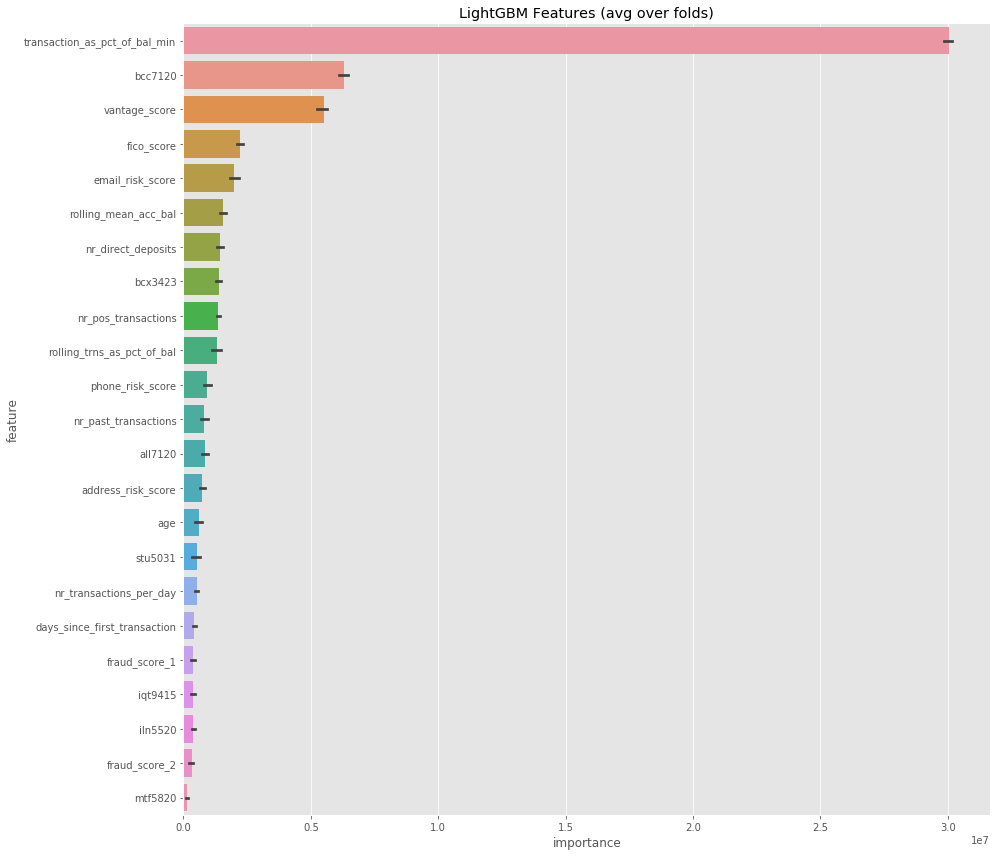

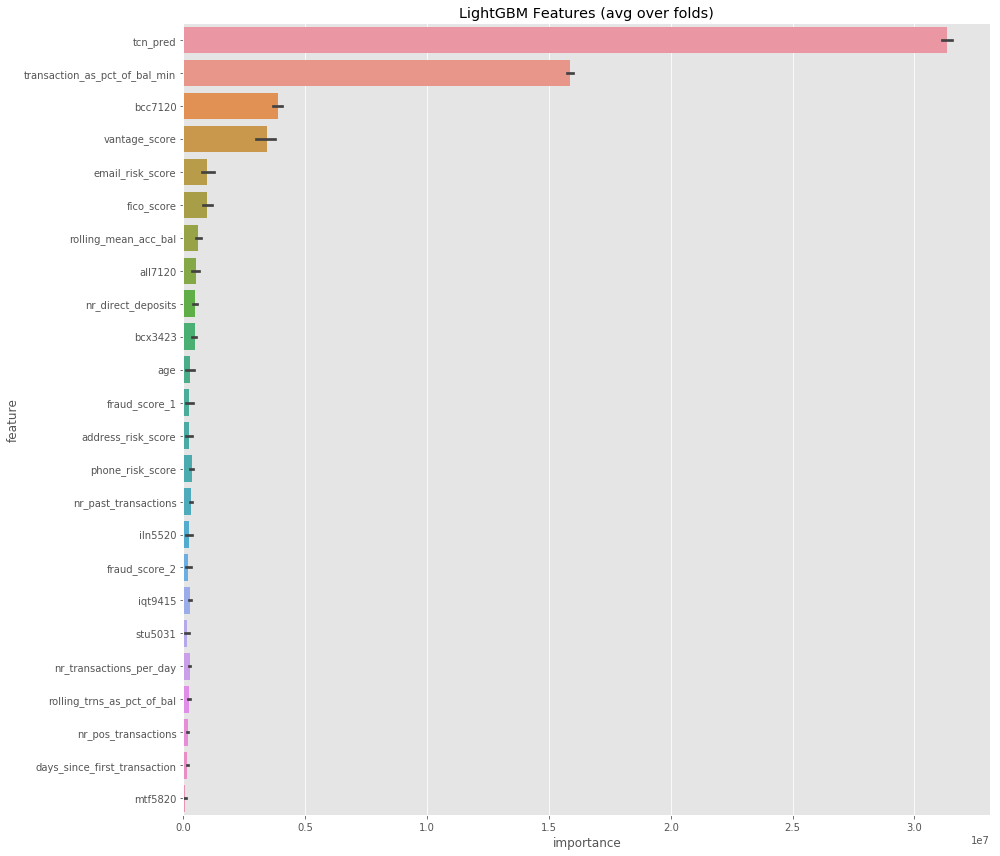

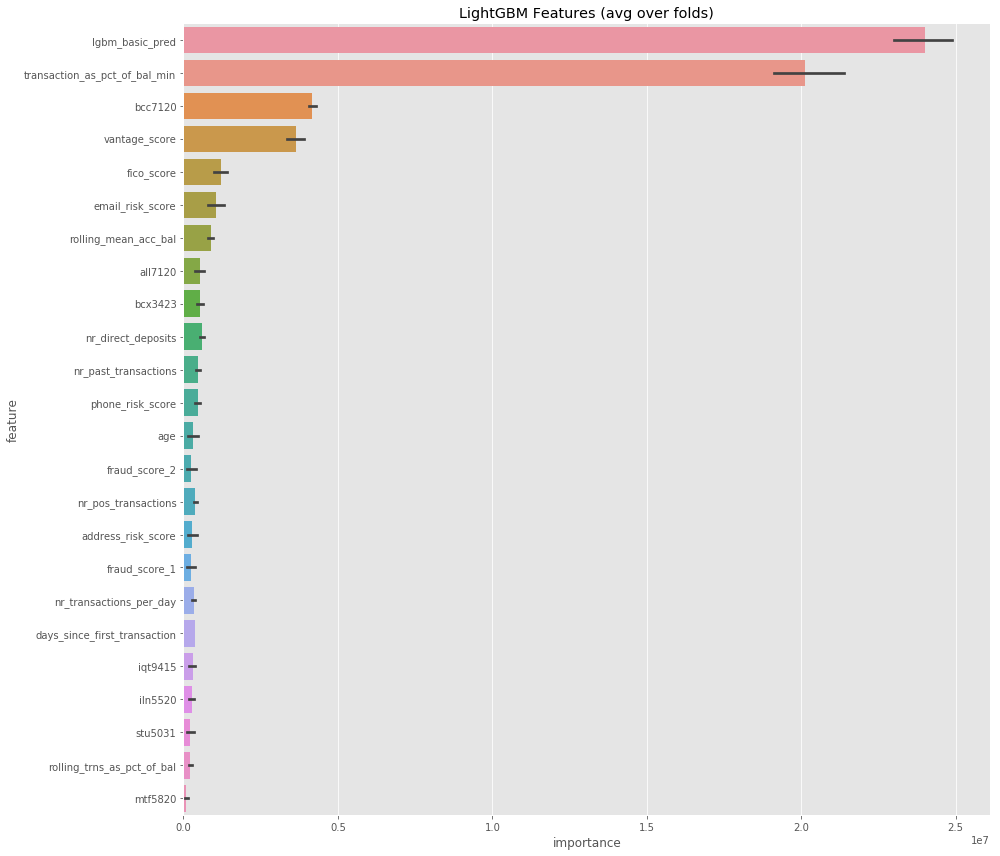

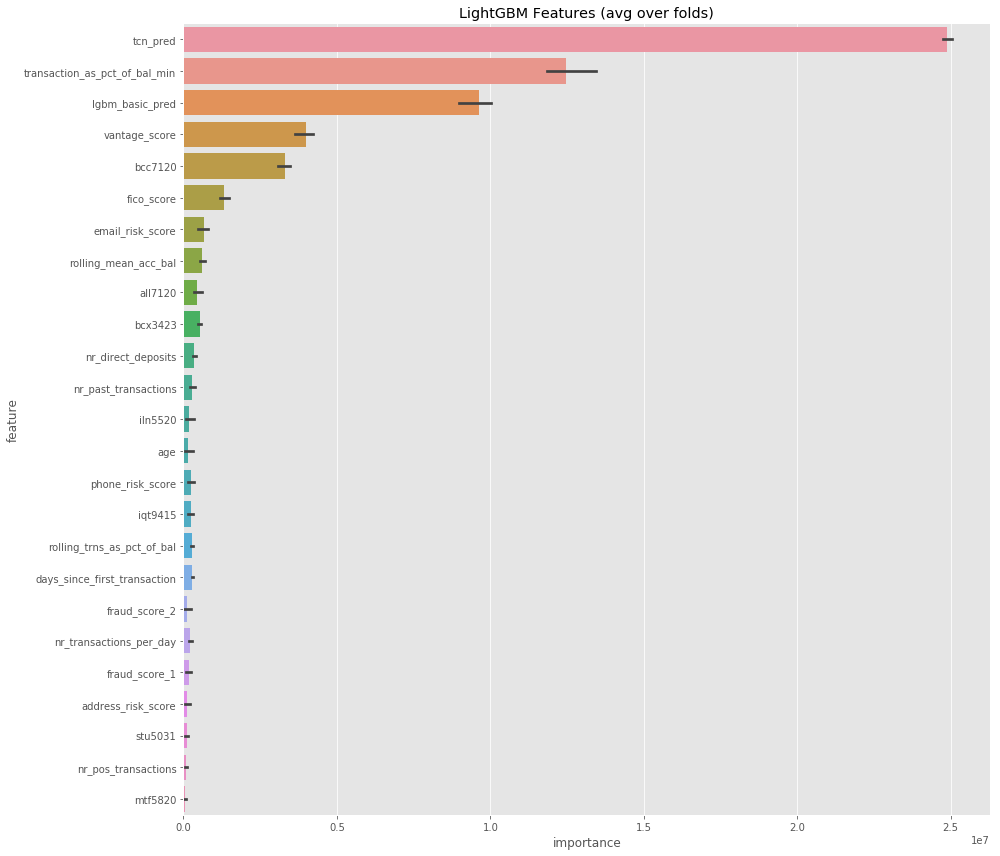

In [42]:
display_importances(tcn_lgbm_object['acct_level_pred']['feature_importance_df'])
display_importances(tcn_lgbm_object['acct_level_w_tcn_pred']['feature_importance_df'])
display_importances(tcn_lgbm_object['acct_level_w_lgbm_pred']['feature_importance_df'])
display_importances(tcn_lgbm_object['acct_level_w_tcn_lgbm_pred']['feature_importance_df'])

#### Finished DF
---

* Order of the transaction-level DataFrames
    * modeling_df_trans.feather
    * modeling_df_trans_with_tcn.feather
    * modeling_df_trans_with_full_validation_preds.feather



* Order of the account-level DataFrames:
    * modeling_df_acct.feather
    * modeling_df_acct_with_every_preds.feather
    * modeling_df_acct_with_full_validation_preds.feather
   

#### Load back everything for further analysis
---

In [ ]:
modeling_df_acct = feather.read_dataframe("data/modeling_df_acct_oot_with_score.feather")
modeling_df_trans = feather.read_dataframe("data/modeling_df_trans_oot_with_score.feather")

In [ ]:
modeling_df_acct.info()

In [5]:
modeling_df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817174 entries, 0 to 817173
Data columns (total 25 columns):
index                             817174 non-null int64
borrower_id                       817174 non-null int64
tcn_pred                          817174 non-null float64
nr_past_returns                   817174 non-null float64
nr_past_transactions              817174 non-null float64
nr_pos_transactions               817174 non-null float64
nr_atm_transactions               817174 non-null float64
nr_direct_deposits                817174 non-null float64
rolling_trns_as_pct_of_bal        817174 non-null float64
rolling_mean_acc_bal              817174 non-null float64
nr_transactions_per_day           817174 non-null float64
transaction_as_pct_of_bal_min     817174 non-null float64
transaction_as_pct_of_balance     817174 non-null float64
card_present_ind                  817174 non-null float64
has_transaction_comment           817174 non-null float64
hr_of_transaction      

## Validation: Out-of-time validation vs. LGBM

#### Train LGBM

In [135]:
# load data

modeling_df_trans = feather.read_dataframe("data/modeling_df_trans.feather")
modeling_df_acct = feather.read_dataframe("data/modeling_df_acct.feather")

sep_date = datetime.datetime(2019, 5, 22)
df_train_oot = modeling_df_trans[modeling_df_trans.transaction_datetime < sep_date]
df_test_oot = modeling_df_trans[modeling_df_trans.transaction_datetime >= sep_date]
print(df_train_oot.shape, df_test_oot.shape)
print(1 / df_train_oot.target.value_counts(normalize=True).iloc[1], 1 / df_test_oot.target.value_counts(normalize=True).iloc[1])

(558623, 23) (258551, 23)
14.810122219571037 105.35900570497147


In [136]:
# one-hot encode 'transaction_code' and 'transaction_type'
modeling_df_lgbm = modeling_df_trans.copy()
t_code = pd.get_dummies(modeling_df_lgbm.transaction_code, dtype=float)
t_type = pd.get_dummies(modeling_df_lgbm.transaction_type, dtype=float)
modeling_df_lgbm = pd.concat([modeling_df_lgbm, t_code, t_type], axis=1, sort=False)
modeling_df_lgbm.drop(['transaction_code', 'transaction_type'], axis=1, inplace=True)
sep_date = datetime.datetime(2019, 5, 22)
df_train_lgbm = modeling_df_lgbm[modeling_df_lgbm.transaction_datetime < sep_date]
df_test_lgbm = modeling_df_lgbm[modeling_df_lgbm.transaction_datetime >= sep_date]
print(df_train_lgbm.shape, df_test_lgbm.shape)
print(1 / df_train_lgbm.target.value_counts(normalize=True).iloc[1], 1 / df_test_lgbm.target.value_counts(normalize=True).iloc[1])

(558623, 75) (258551, 75)
14.810122219571037 105.35900570497147


* DataFrame that will be used in this validation: They are all OOT
    * `df_train_lgbm`: one-hot encoded train df for transactions data 
    * `df_test_lgbm`: one-hot encoded test df for transactions data 
    * `df_train_oot`: train df for transactions data 
    * `df_test_oot`: test df for transactions data 

In [137]:
from rdsutils.lightgbm_models import train_validate_lgb

features_num = ['hr_of_transaction', 'has_transaction_comment', 'card_present_ind', 'days_since_first_transaction',
                'transaction_as_pct_of_balance', 'nr_past_transactions', 'international_transaction_flag']
features_premium = ['nr_atm_transactions', 'nr_direct_deposits', 'rolling_trns_as_pct_of_bal',
                    'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 'nr_past_returns', 
                    'nr_transactions_per_day', 'nr_pos_transactions']
features_cat = ['transaction_code', 'transaction_type']
target_col = ['target']
meta_cols = ['borrower_id', 'index', 'transaction_datetime']

# use a train fold for calculating pos_weight
# by construction, each fold has same pos_weight
pos_weight = 1/df_train_lgbm.target.value_counts(normalize=True).loc[True]

seed = 12345
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 4,
    "num_leaves" : 10,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.4,
    "lambda_l1": 20,
    "min_data_in_leaf": 30,
    "scale_pos_weight": pos_weight, #df_train_basic['target'].count() / df_train_basic['target'].sum(),
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : seed,
    "verbosity" : 1,
    "seed": seed
}

# basic features


# features basic contains all the basic numerical variables and one hot encoded categorical variables. 
# just to make sure we won't include unnecessary features
features_basic = list(set(df_train_lgbm.columns) - set(target_col) - set(meta_cols) - set(features_cat) - set(features_premium))

print('-' * 80)
print('current features: ',features_basic)
print('pos weight: ', pos_weight)
print('-' * 80)

%time pred, feature_importance_df, model, auc = train_validate_lgb(df_train_lgbm, df_test_lgbm, features_basic, params, seed=12345, early_stopping_rounds=1000, verbose_eval=500)

--------------------------------------------------------------------------------
current features:  ['DDCK', 'DWMBR', 'DWATM', 'DDCHGOFF', 'DWSLROTP', 'international_transaction_flag', 'DD', 'ACHINDD', 'days_since_first_transaction', 'transaction_as_pct_of_balance', 'ACHDWP2P', 'DPND', 'DDMKT', 'DDCRDBILLREF', 'randf', 'DDPAYOUTADJ', 'DDMBR', 'POS', 'user_id', 'DDPROMO', 'hr_of_transaction', 'CHECK', 'DWTRF', 'ACHDDIN', 'TREASURYCHECK', 'ATM', 'DCWIZERO', 'OTHER', 'POSDW', 'INTEREST PAID', 'BILLPAY', 'ACHDW', 'DWACHRET', 'DPNC', 'DWATMI', 'DCWI', 'DDPC', 'DDBILLPAY', 'DDWRTOFF', 'DWCRDBILLPAY', 'has_transaction_comment', 'P2P', 'DW', 'card_present_ind', 'ACHDWIN', 'DDRAFCUS', 'nr_past_transactions', 'DDATMREFUND', 'DDRAFNEW', 'DDTRF', 'DIPD', 'DWBILLPAY', 'DWCARDREF', 'DDCC', 'DWCK', 'ACHDD', 'POSDD', 'ONUSCHECK', 'DWCKCB', 'ACH', 'DDA2ATXFR', 'DDFRDWO', 'DDACHRET']
pos weight:  14.810122219571037
--------------------------------------------------------------------------------
Training

In [138]:
modeling_df_lgbm['lgbm_pred'] = model.predict(modeling_df_lgbm[features_basic], num_iteration=model.best_iteration)

In [139]:
inference_df_oot = feather.read_dataframe("data/tcn_pred_oot.feather")
inference_df_oot = pd.merge(inference_df_oot, modeling_df_lgbm[['index', 'lgbm_pred']], on=['index'])

In [140]:
# save the dataframe with both validation scores
inference_df_oot.to_feather("data/modeling_df_oot_with_score.feather")

# agg. all validation objects for lgbm
lgbm_oot_validation_object = {'lgbm_pred': pred, 
                              'feature_importance_df': feature_importance_df,
                              'model': model, 
                              'auc': auc}
torch.save(lgbm_oot_validation_object, 'data/lgbm_oot_validation_object')

### Analysis

In [45]:
lgbm_oot_validation_object = torch.load('data/lgbm_oot_validation_object')
inference_df_oot = feather.read_dataframe("data/modeling_df_oot_with_score.feather")

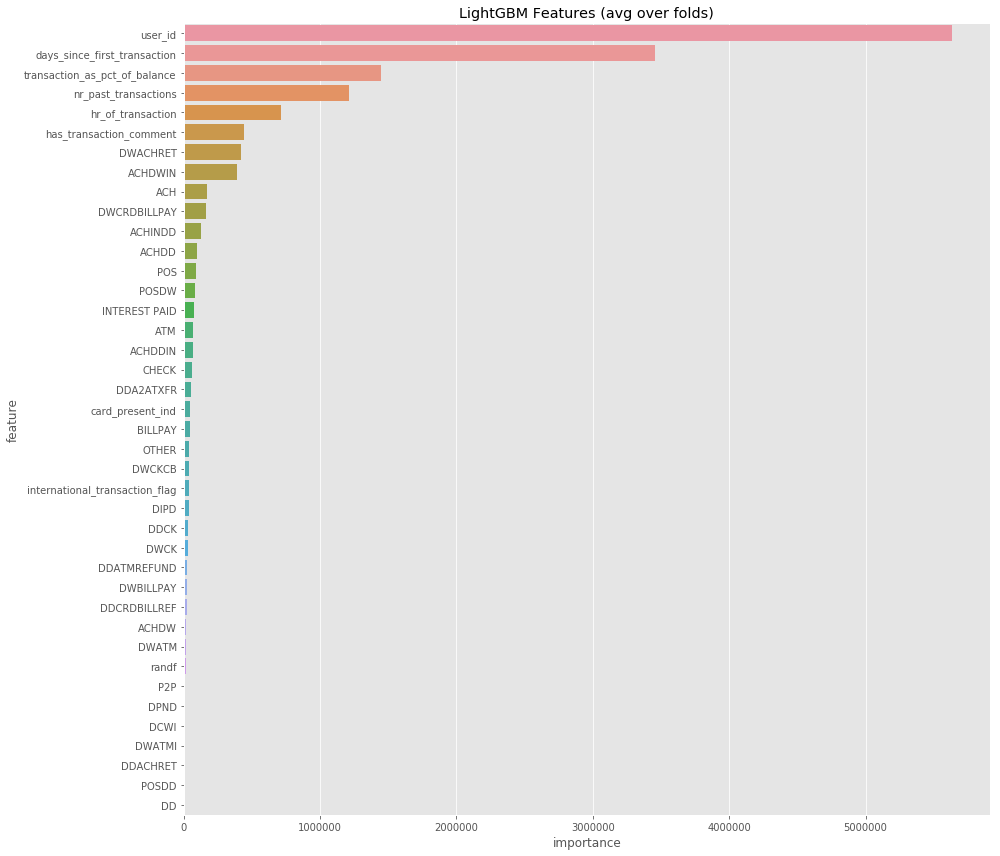

In [46]:
display_importances(lgbm_oot_validation_object['feature_importance_df'])

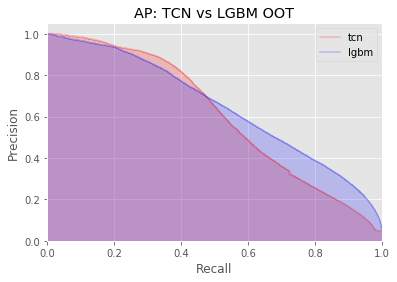

In [9]:
# average precision
y_scores = [(inference_df_oot.tcn_pred, 'tcn'),
            (inference_df_oot.lgbm_pred, 'lgbm')]
colors = ['r', 'b']
plot_pr_curve_mult(inference_df_oot.target, y_scores, 'AP: TCN vs LGBM OOT', colors)
plt.show()

In [144]:
print("TCN")
build_summary(inference_df_oot.target, inference_df_oot.tcn_pred, np.linspace(90, 100, 10, endpoint=False))

TCN


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.117483,65.236036,71.234411,82318,28617,53701,11556
1,91.0,0.133742,62.452071,68.740199,73546,27615,45931,12558
2,92.0,0.152188,59.450240,65.987106,65374,26509,38865,13664
3,93.0,0.172579,55.769802,62.980111,57203,25301,31902,14872
4,94.0,0.200848,50.996308,59.808827,49031,24027,25004,16146
5,95.0,0.229415,45.187107,55.748886,40859,22396,18463,17777
6,96.0,0.288417,37.097317,51.181142,32687,20561,12126,19612
7,97.0,0.380832,26.195138,45.040201,24516,18094,6422,22079
8,98.0,0.601579,13.056779,35.372016,16344,14210,2134,25963
9,99.0,0.861012,5.323054,19.259204,8172,7737,435,32436


In [145]:
print("LGBM")
build_summary(inference_df_oot.target, inference_df_oot.lgbm_pred, np.linspace(90, 100, 10, endpoint=False))

LGBM


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.649559,60.840941,79.655490,81718,32000,49718,8173
1,91.0,0.688946,58.084736,76.735618,73546,30827,42719,9346
2,92.0,0.728811,54.894912,73.400045,65374,29487,35887,10686
3,93.0,0.768791,51.210601,69.472033,57203,27909,29294,12264
4,94.0,0.805571,46.958047,64.737510,49031,26007,23024,14166
5,95.0,0.840015,41.657897,59.338362,40859,23838,17021,16335
6,96.0,0.872847,35.081225,52.821547,32687,21220,11467,18953
7,97.0,0.905473,27.145538,44.460210,24516,17861,6655,22312
8,98.0,0.940998,16.489232,33.975556,16344,13649,2695,26524
9,99.0,0.981791,6.130690,19.094914,8172,7671,501,32502


### TCN performance by OOT by folds
---
On Transactions Data

[2019-05-22, 2019-05-29)
[2019-05-29, 2019-06-05)
[2019-06-05, 2019-06-12)
[2019-06-12, 2019-06-19)
[2019-06-19, 2019-06-26)
False    43140
True       610
Name: target, dtype: int64
n_data:  43750
lgbm ap:  0.2406540753202316
tcn ap:  0.34088972266441037
false vs true ratio:  71.72131147540983


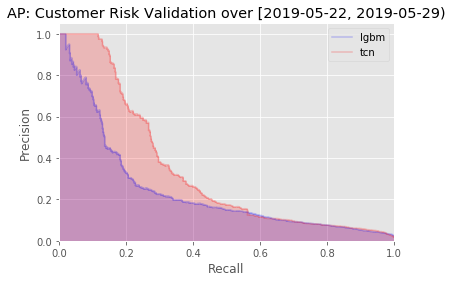

False    63922
True       568
Name: target, dtype: int64
n_data:  64490
lgbm ap:  0.15246192256340096
tcn ap:  0.22431009893939385
false vs true ratio:  113.53873239436619


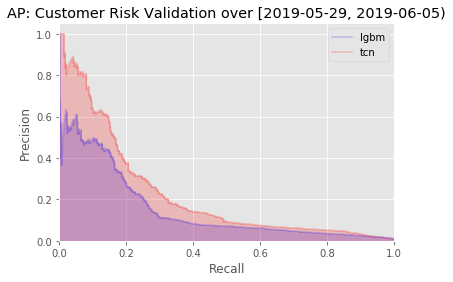

False    57002
True       678
Name: target, dtype: int64
n_data:  57680
lgbm ap:  0.22820453880646666
tcn ap:  0.22568716854598117
false vs true ratio:  85.07374631268436


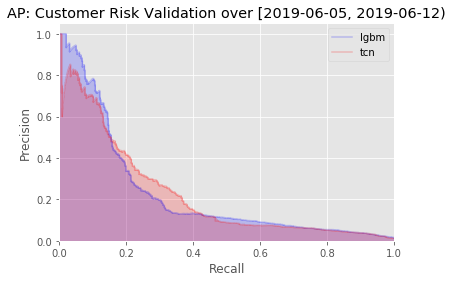

False    61982
True       418
Name: target, dtype: int64
n_data:  62400
lgbm ap:  0.17128757846399711
tcn ap:  0.23062965488602663
false vs true ratio:  149.2822966507177


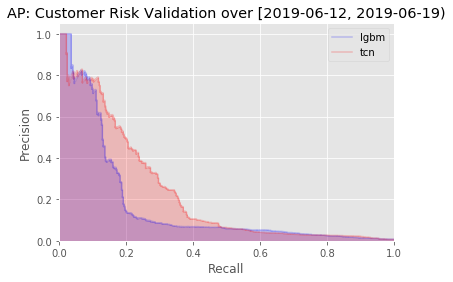

False    30051
True       180
Name: target, dtype: int64
n_data:  30231
lgbm ap:  0.07517263326746744
tcn ap:  0.13216120138410908
false vs true ratio:  167.95


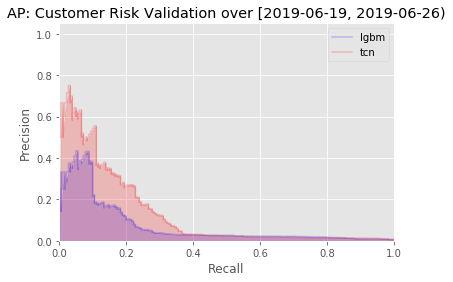

In [43]:
sep_date = datetime.datetime(2019, 5, 22)
bins = [sep_date + datetime.timedelta(7*i,0,0) for i in range(6)]
inference_df_oot = inference_df_oot[inference_df_oot.reporting_date >= sep_date]
inference_df_oot['reporting_date'] = pd.to_datetime(inference_df_oot.transaction_datetime.dt.date)
inference_df_oot['date_bins'] = pd.cut(inference_df_oot.reporting_date, bins, right=False)
bins = sorted(inference_df_oot['date_bins'].unique())

for i in bins:
    print(i)

# on test data
for b in bins:
    df_tmp = inference_df_oot[inference_df_oot.date_bins == b].copy()
    print(df_tmp.target.value_counts())
    print("n_data: ", len(df_tmp))
    print("lgbm ap: ", average_precision_score(df_tmp.target, df_tmp.lgbm_pred))
    print("tcn ap: ", average_precision_score(df_tmp.target, df_tmp.tcn_pred))
    print("false vs true ratio: ", 1/df_tmp.target.value_counts(normalize=True).loc[True])
    
    y_scores = [(df_tmp.lgbm_pred, 'lgbm'),
                (df_tmp.tcn_pred, 'tcn')]
    colors = ['b', 'r']
    
    plot_pr_curve_mult(df_tmp.target, y_scores, 'AP: Customer Risk Validation over {}'.format(b), colors)
    plt.show()

### Customer Risk Model: TCN + LGBM
---

In [146]:
# account level data
df = feather.read_dataframe("data/df.feather")
df['borrower_id'] = df['borrower_id'].astype(int)
inference_df_oot = feather.read_dataframe("data/modeling_df_oot_with_score.feather")
inference_df_oot['borrower_id'] = inference_df_oot['borrower_id_x'].astype(int)
inference_df_oot.drop(['borrower_id_x', 'borrower_id_y'], inplace=True, axis=1)
inference_df_oot.sort_values(['index', 'transaction_datetime'], inplace=True)
df_acct = pd.merge_asof(df[df.columns[~df.columns.isin(['transaction_datetime'])]], 
                        inference_df_oot[['lgbm_pred',
                                          'tcn_pred',
                                          'transaction_type',
                                          'card_present_ind',
                                          'transaction_as_pct_of_balance',
                                          'hr_of_transaction',
                                          'randf',
                                          'transaction_code',
                                          'has_transaction_comment',
                                          'index',
                                          'international_transaction_flag',
                                          'borrower_id', 
                                          'transaction_datetime']], left_on='reporting_date', right_on='transaction_datetime', by='borrower_id')

df_acct['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df_acct['age'] = (pd.datetime.today() - df_acct['date_of_birth']).dt.days

modeling_df_acct = df_acct[~df_acct['latest_acc_bal'].isna() & ~df_acct['is_indeterminate']]
modeling_df_acct = modeling_df_acct.drop_duplicates(subset=['borrower_id', 'reporting_date_id'], keep='first')

In [147]:
sep_date = datetime.datetime(2019, 5, 22)
df_train_oot = modeling_df_acct[modeling_df_acct.reporting_date < sep_date]
df_test_oot = modeling_df_acct[modeling_df_acct.reporting_date >= sep_date]

In [148]:
features = ['fico_score', 'vantage_score', 'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'iln5520', 'bcx3423', 'days_since_first_transaction',
            'stu5031', 'fraud_score_1', 'fraud_score_2', 'phone_risk_score', 'email_risk_score', 'address_risk_score', 'age',
            'nr_past_transactions', 'nr_pos_transactions', 'nr_direct_deposits', 'rolling_trns_as_pct_of_bal', 'rolling_mean_acc_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_bal_min']

features_tcn = features + ['tcn_pred']
features_lgbm = features + ['lgbm_pred']
features_tcn_lgbm = features + ['tcn_pred', 'lgbm_pred']
target_col_name = 'target'

seed = 12345 
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 3,
    "num_leaves" : 9,
    "learning_rate" : 0.05,
    "feature_fraction" : 0.5,
    "lambda_l1": 5,
    "min_data_in_leaf": 30,
    "scale_pos_weight": df_train_oot['target'].count() / df_train_oot['target'].sum(),
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : seed,
    "verbosity" : 1,
    "seed": seed
}

print("training on baseline, no transaction risk scores")
print("features: ", features)
print("\n")

training on baseline, no transaction risk scores
features:  ['fico_score', 'vantage_score', 'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'iln5520', 'bcx3423', 'days_since_first_transaction', 'stu5031', 'fraud_score_1', 'fraud_score_2', 'phone_risk_score', 'email_risk_score', 'address_risk_score', 'age', 'nr_past_transactions', 'nr_pos_transactions', 'nr_direct_deposits', 'rolling_trns_as_pct_of_bal', 'rolling_mean_acc_bal', 'nr_transactions_per_day', 'transaction_as_pct_of_bal_min']




In [149]:
%time pred, feature_importance_df, model, auc = train_validate_lgb(df_train_oot, df_test_oot, features, params, seed=12345, early_stopping_rounds=100, verbose_eval=500)

Training until validation scores don't improve for 100 rounds.
[500]	train's auc: 0.993384	test's auc: 0.989783
[1000]	train's auc: 0.996724	test's auc: 0.99201
[1500]	train's auc: 0.998192	test's auc: 0.993022
[2000]	train's auc: 0.998944	test's auc: 0.993625
[2500]	train's auc: 0.99935	test's auc: 0.993961
[3000]	train's auc: 0.999598	test's auc: 0.99428
[3500]	train's auc: 0.999742	test's auc: 0.994443
Early stopping, best iteration is:
[3404]	train's auc: 0.999724	test's auc: 0.99447
CPU times: user 31min 34s, sys: 12.1 s, total: 31min 46s
Wall time: 15min 54s


In [150]:
%time pred_tcn, feature_importance_df_tcn, model_tcn, auc_tcn = train_validate_lgb(df_train_oot, df_test_oot, features_tcn, params, seed=12345, early_stopping_rounds=100, verbose_eval=500)

Training until validation scores don't improve for 100 rounds.
[500]	train's auc: 0.996941	test's auc: 0.995019
[1000]	train's auc: 0.998758	test's auc: 0.996046
[1500]	train's auc: 0.999404	test's auc: 0.996473
[2000]	train's auc: 0.999685	test's auc: 0.996759
Early stopping, best iteration is:
[2352]	train's auc: 0.9998	test's auc: 0.9969
CPU times: user 21min 43s, sys: 8.4 s, total: 21min 52s
Wall time: 10min 56s


In [151]:
%time pred_lgbm, feature_importance_df_lgbm, model_lgbm, auc_lgbm = train_validate_lgb(df_train_oot, df_test_oot, features_lgbm, params, seed=12345, early_stopping_rounds=100, verbose_eval=500)

Training until validation scores don't improve for 100 rounds.
[500]	train's auc: 0.996431	test's auc: 0.994357
[1000]	train's auc: 0.998471	test's auc: 0.9953
[1500]	train's auc: 0.999255	test's auc: 0.995853
[2000]	train's auc: 0.9996	test's auc: 0.996235
[2500]	train's auc: 0.999784	test's auc: 0.996496
[3000]	train's auc: 0.999876	test's auc: 0.996716
Early stopping, best iteration is:
[3135]	train's auc: 0.999892	test's auc: 0.996771
CPU times: user 28min 46s, sys: 10.7 s, total: 28min 57s
Wall time: 14min 29s


In [152]:
%time modeling_df_acct['lgbm_pred'] = model.predict(modeling_df_acct[features], num_iteration=model.best_iteration)
%time modeling_df_acct['tcn_lgbm_pred'] = model_tcn.predict(modeling_df_acct[features_tcn], num_iteration=model_tcn.best_iteration)
%time modeling_df_acct['lgbm_lgbm_pred'] = model_lgbm.predict(modeling_df_acct[features_lgbm], num_iteration=model_lgbm.best_iteration)

CPU times: user 7min 12s, sys: 1.09 s, total: 7min 13s
Wall time: 3min 38s
CPU times: user 5min 26s, sys: 1.13 s, total: 5min 27s
Wall time: 2min 44s
CPU times: user 6min 56s, sys: 1.74 s, total: 6min 58s
Wall time: 3min 30s


In [153]:
modeling_df_acct.reset_index(drop=True).to_feather("data/modeling_df_acct_oot_with_score.feather")

### Extract the validation data

In [6]:
modeling_df_acct = feather.read_dataframe("data/modeling_df_acct_oot_with_score.feather")

In [7]:
sep_date = datetime.datetime(2019, 5, 22)
modeling_df_acct_oot = modeling_df_acct[modeling_df_acct.reporting_date >= sep_date]

In [118]:
print("No Score")
lgbm_score_summary = build_summary(modeling_df_acct_oot.target, modeling_df_acct_oot.lgbm_pred, np.linspace(95, 100, 10, endpoint=False))
lgbm_score_summary

No Score


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,95.0,0.802368,9.095917,88.490988,32674,29702,2972,3863
1,95.5,0.915657,4.332155,83.819455,29408,28134,1274,5431
2,96.0,0.958694,2.474945,75.957098,26142,25495,647,8070
3,96.5,0.980042,0.856718,67.576344,22878,22682,196,10883
4,97.0,0.990019,0.448888,58.143900,19604,19516,88,14049
5,97.5,0.995419,0.103982,48.657828,16349,16332,17,17233
6,98.0,0.998063,0.130079,38.885744,13069,13052,17,20513
7,98.5,0.999174,0.000000,29.259645,9821,9821,0,23744
8,99.0,0.999748,0.000000,19.478624,6538,6538,0,27027
9,99.5,0.999957,0.000000,9.736332,3268,3268,0,30297


In [119]:
print("TCN")
tcn_score_summary = build_summary(modeling_df_acct_oot.target, modeling_df_acct_oot.tcn_lgbm_pred, np.linspace(95, 100, 10, endpoint=False))
tcn_score_summary

TCN


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,95.0,0.820746,5.345123,92.170416,32684,30937,1747,2628
1,95.5,0.958805,1.591566,86.211828,29405,28937,468,4628
2,96.0,0.986960,0.795350,77.294801,26152,25944,208,7621
3,96.5,0.994939,0.559538,67.772978,22876,22748,128,10817
4,97.0,0.997830,0.443787,58.146879,19604,19517,87,14048
5,97.5,0.998946,0.232601,48.559511,16337,16299,38,17266
6,98.0,0.999462,0.129920,38.933413,13085,13068,17,20497
7,98.5,0.999776,0.173328,29.170267,9808,9791,17,23774
8,99.0,0.999923,0.000000,19.472665,6536,6536,0,27029
9,99.5,0.999980,0.000000,9.736332,3268,3268,0,30297


In [52]:
print("with LGBM score")
build_summary(modeling_df_acct_oot.target, modeling_df_acct_oot.lgbm_lgbm_pred, np.linspace(90, 100, 10, endpoint=False))

with LGBM score


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.024699,50.149167,97.077313,65363,32584,32779,981
1,91.0,0.043506,45.020489,96.332489,58811,32334,26477,1231
2,92.0,0.076553,38.679317,95.504245,52276,32056,20220,1509
3,93.0,0.146363,30.637721,94.524058,45741,31727,14014,1838
4,94.0,0.308361,20.596261,92.760316,39211,31135,8076,2430
5,95.0,0.649714,10.106204,87.504841,32673,29371,3302,4194
6,96.0,0.974543,2.953554,75.572769,26138,25366,772,8199
7,97.0,0.998383,0.780493,57.947266,19603,19450,153,14115
8,98.0,0.999921,0.000000,38.954268,13075,13075,0,20490
9,99.0,0.999996,0.000000,19.490541,6542,6542,0,27023


#### Precision and Recall on validation set

**Compare with tcn, without tcn, with lgbm**

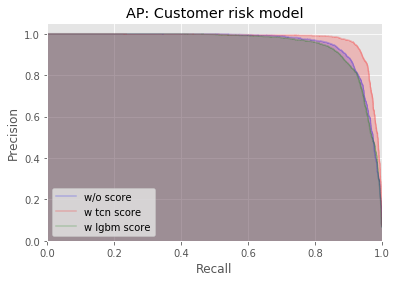

In [22]:
# average precision
y_scores = [(modeling_df_acct_oot.lgbm_pred, 'w/o score'),
            (modeling_df_acct_oot.tcn_lgbm_pred, 'w tcn score'),
            (modeling_df_acct_oot.lgbm_lgbm_pred, 'w lgbm score')]
colors = ['b', 'r', 'g']
plot_pr_curve_mult(modeling_df_acct_oot.target, y_scores, 'AP: Customer risk model', colors)
plt.show()

**Compare with/without tcn**

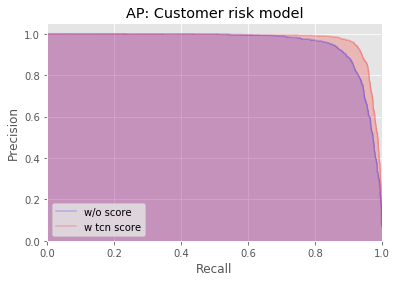

In [28]:
# average precision
y_scores = [(modeling_df_acct_oot.lgbm_pred, 'w/o score'),
            (modeling_df_acct_oot.tcn_lgbm_pred, 'w tcn score')]
colors = ['b', 'r']
plot_pr_curve_mult(modeling_df_acct_oot.target, y_scores, 'AP: Customer risk model', colors)
plt.show()

#### Precision and Recall on validation w/o previous returns

**Compare with tcn, without tcn, with lgbm**

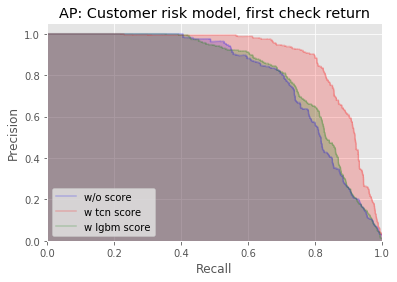

In [23]:
# average precision of 1st return
modeling_df_acct_oot_1st_return = modeling_df_acct_oot[(modeling_df_acct_oot['nr_past_returns'] == 0)]

y_scores = [(modeling_df_acct_oot_1st_return.lgbm_pred, 'w/o score'),
            (modeling_df_acct_oot_1st_return.tcn_lgbm_pred, 'w tcn score'),
            (modeling_df_acct_oot_1st_return.lgbm_lgbm_pred, 'w lgbm score')]
colors = ['b', 'r', 'g']
plot_pr_curve_mult(modeling_df_acct_oot_1st_return.target, y_scores, 'AP: Customer risk model, first check return', colors)
plt.show()

**Compare with/without tcn**

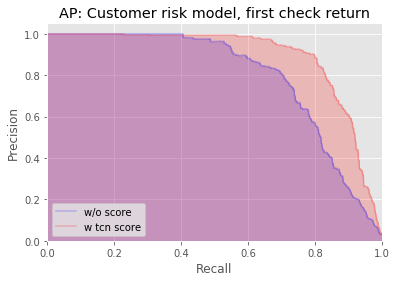

In [8]:
# average precision of 1st return
modeling_df_acct_oot_1st_return = modeling_df_acct_oot[(modeling_df_acct_oot['nr_past_returns'] == 0)]

y_scores = [(modeling_df_acct_oot_1st_return.lgbm_pred, 'w/o score'),
            (modeling_df_acct_oot_1st_return.tcn_lgbm_pred, 'w tcn score')]
colors = ['b', 'r']
plot_pr_curve_mult(modeling_df_acct_oot_1st_return.target, y_scores, 'AP: Customer risk model, first check return', colors)
plt.show()

#### Precision and Recall on new borrowers

In [30]:
df_train_oot.shape, df_test_oot.shape

((1443525, 59), (653443, 59))

**Compare with tcn, without tcn, with lgbm**

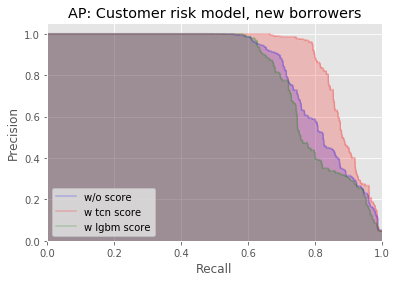

In [32]:
train_ids = df_train_oot.borrower_id.unique()
test_ids = df_test_oot.borrower_id.unique()
new_ids = list(set(test_ids) - set(train_ids))

# average precision of 1st return
modeling_df_acct_oot_new_bid = modeling_df_acct_oot[modeling_df_acct_oot['borrower_id'].isin(new_ids)]

y_scores = [(modeling_df_acct_oot_new_bid.lgbm_pred, 'w/o score'),
            (modeling_df_acct_oot_new_bid.tcn_lgbm_pred, 'w tcn score'),
            (modeling_df_acct_oot_new_bid.lgbm_lgbm_pred, 'w lgbm score')]
colors = ['b', 'r', 'g']
plot_pr_curve_mult(modeling_df_acct_oot_new_bid.target, y_scores, 'AP: Customer risk model, new borrowers', colors)
plt.show()

**Compare with/without tcn**

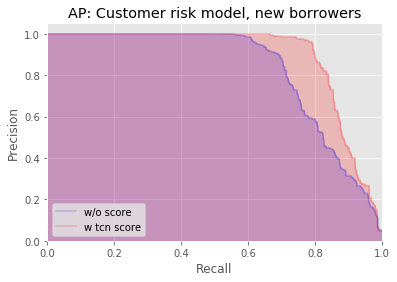

In [33]:
train_ids = df_train_oot.borrower_id.unique()
test_ids = df_test_oot.borrower_id.unique()
new_ids = list(set(test_ids) - set(train_ids))

# average precision of 1st return
modeling_df_acct_oot_new_bid = modeling_df_acct_oot[modeling_df_acct_oot['borrower_id'].isin(new_ids)]

y_scores = [(modeling_df_acct_oot_new_bid.lgbm_pred, 'w/o score'),
            (modeling_df_acct_oot_new_bid.tcn_lgbm_pred, 'w tcn score')]
colors = ['b', 'r']
plot_pr_curve_mult(modeling_df_acct_oot_new_bid.target, y_scores, 'AP: Customer risk model, new borrowers', colors)
plt.show()

#### Precision and Recall bined by days since sep_date

In [25]:
bins = [datetime.datetime(2019,5,22) + datetime.timedelta(7*i,0,0) for i in range(6)]
modeling_df_acct_oot['date_bins'] = pd.cut(modeling_df_acct_oot.reporting_date, bins, right=False)
bins = modeling_df_acct_oot['date_bins'].unique()

In [26]:
for i in bins:
    print(i)

[2019-05-22, 2019-05-29)
[2019-05-29, 2019-06-05)
[2019-06-05, 2019-06-12)
[2019-06-12, 2019-06-19)
[2019-06-19, 2019-06-26)


False    125971
True      10767
Name: target, dtype: int64
lgbm ap:  0.9864905419477881
tcn_lgbm ap:  0.9933262103698912
lgbm_lgbm ap:  0.9829828470838117
false vs true ratio:  12.699730658493545


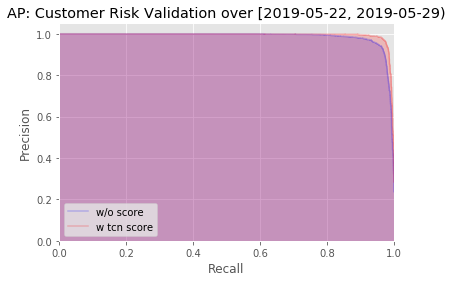

False    131138
True       9152
Name: target, dtype: int64
lgbm ap:  0.969524987527206
tcn_lgbm ap:  0.9833840430177028
lgbm_lgbm ap:  0.9639156281106721
false vs true ratio:  15.328889860139862


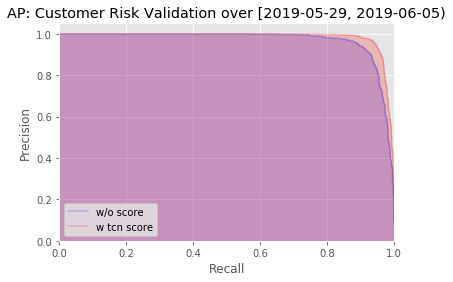

False    136591
True       6435
Name: target, dtype: int64
lgbm ap:  0.9370478878168358
tcn_lgbm ap:  0.9625479202226045
lgbm_lgbm ap:  0.9302638395287038
false vs true ratio:  22.226262626262628


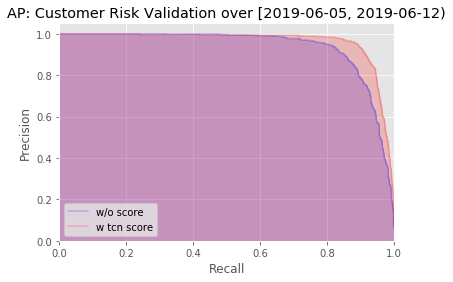

False    141769
True       4803
Name: target, dtype: int64
lgbm ap:  0.8929552628968174
tcn_lgbm ap:  0.936127018184538
lgbm_lgbm ap:  0.889876699443903
false vs true ratio:  30.516760358109515


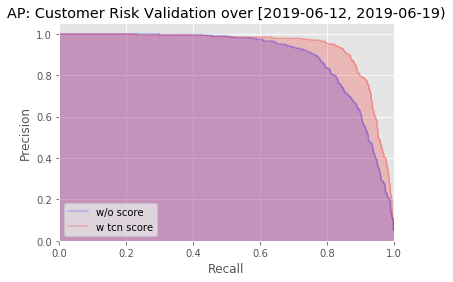

False    84409
True      2408
Name: target, dtype: int64
lgbm ap:  0.8537636541192684
tcn_lgbm ap:  0.9124662346049524
lgbm_lgbm ap:  0.8486001219390256
false vs true ratio:  36.05357142857143


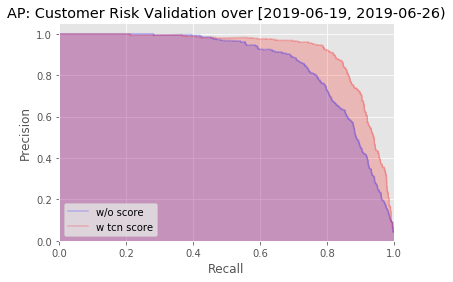

In [34]:
# on test data
for b in bins:
    df_tmp = modeling_df_acct_oot[modeling_df_acct_oot.date_bins == b].copy()
    print(df_tmp.target.value_counts())
    print("lgbm ap: ", average_precision_score(df_tmp.target, df_tmp.lgbm_pred))
    print("tcn_lgbm ap: ", average_precision_score(df_tmp.target, df_tmp.tcn_lgbm_pred))
    print("lgbm_lgbm ap: ", average_precision_score(df_tmp.target, df_tmp.lgbm_lgbm_pred))
    print("false vs true ratio: ", 1/df_tmp.target.value_counts(normalize=True).loc[True])
    
    y_scores = [(df_tmp.lgbm_pred, 'w/o score'),
                (df_tmp.tcn_lgbm_pred, 'w tcn score')]
    colors = ['b', 'r']
    
    plot_pr_curve_mult(df_tmp.target, y_scores, 'AP: Customer Risk Validation over {}'.format(b), colors)
    plt.show()

#### Feature Importance

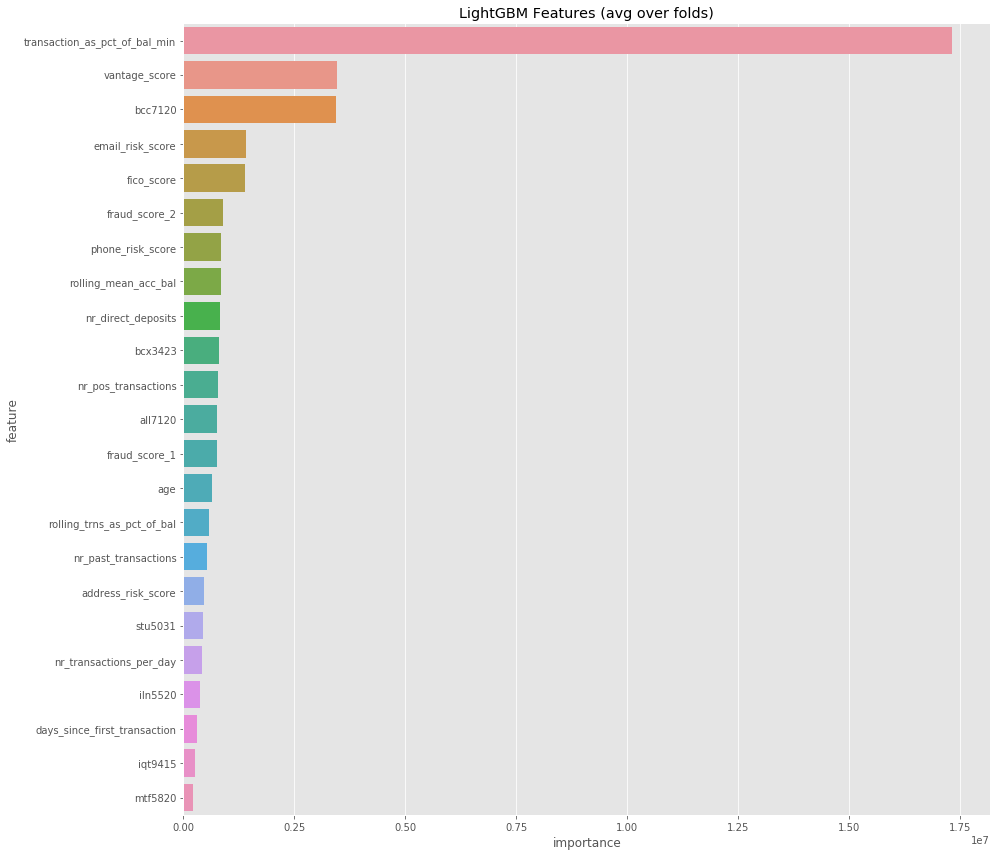

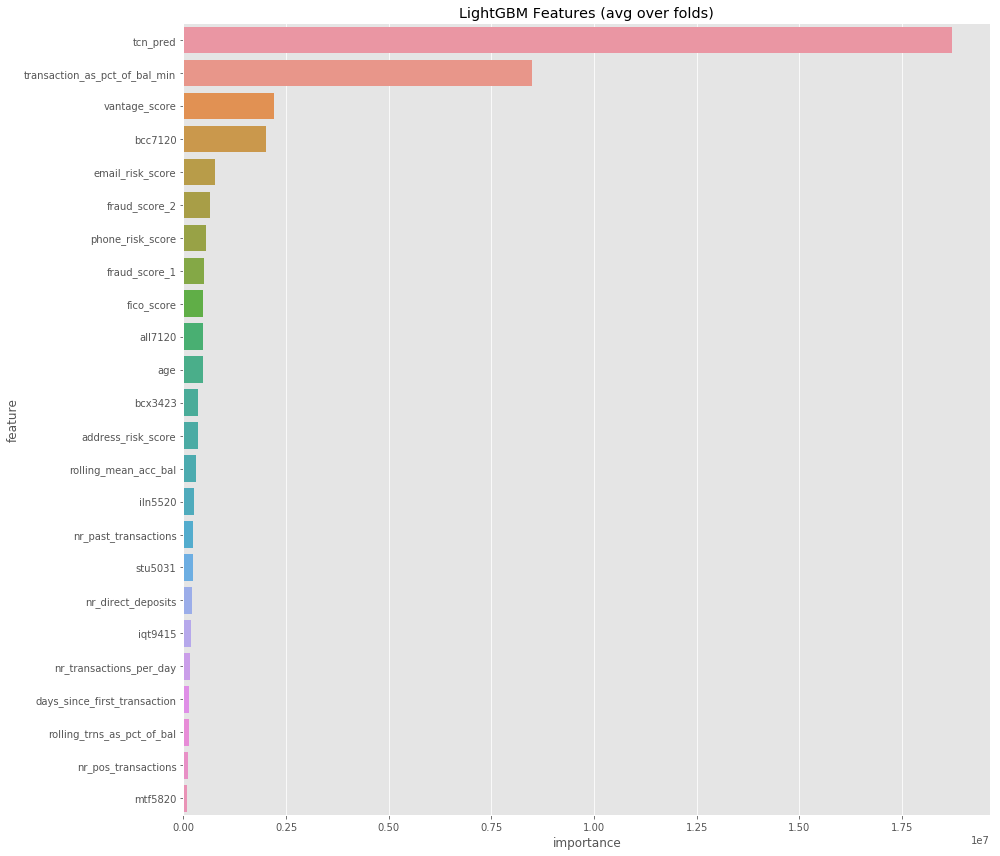

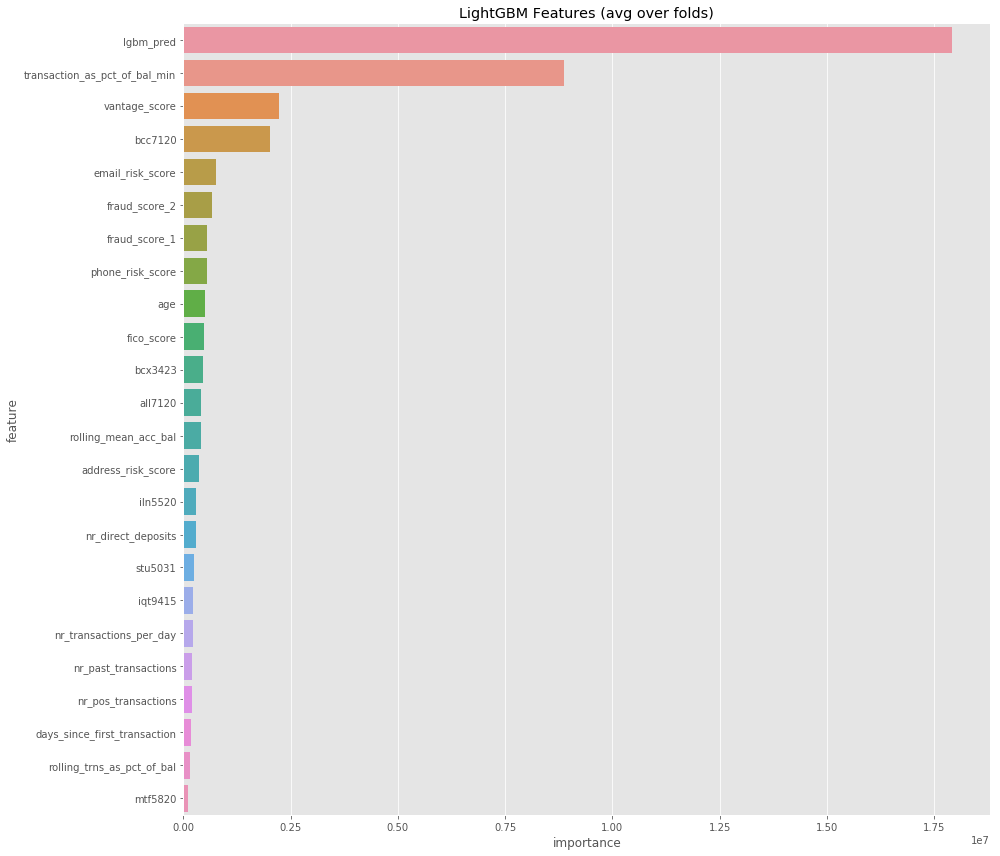

In [165]:
display_importances(feature_importance_df)
display_importances(feature_importance_df_tcn)
display_importances(feature_importance_df_lgbm)